<a href="https://colab.research.google.com/github/achiever04/GWMS/blob/main/Grey_Water_Management_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.0 MB/s eta 0:00:00
✓ All dependencies loaded successfully!
✓ SHAP available: True
✓ Keras available: True
Generating synthetic grey water dataset...
✓ Dataset generated: 5000 samples, 15 features

Quality Distribution:
quality
Safe       3662
Warning     765
Unsafe      573
Name: count, dtype: int64

First few rows:
                      timestamp  hour  day_of_week        pH  turbidity  \
0 2025-08-16 14:23:33.589947000    14            5  7.748357        5.0   
1 2025-08-16 15:15:24.612151440    15            5  7.430868        5.0   
2 2025-08-16 16:07:15.634355881    16            5  7.823844        5.0   
3 2025-08-16 16:59:06.656560322    16            5  8.261515        5.0   
4 2025-08-16 17:50:57.678764763    17            5  7.382923        5.0   

          tds  temperature   microbes  chlorine  tank_level  flow_rate  \
0  332.150527    24.56

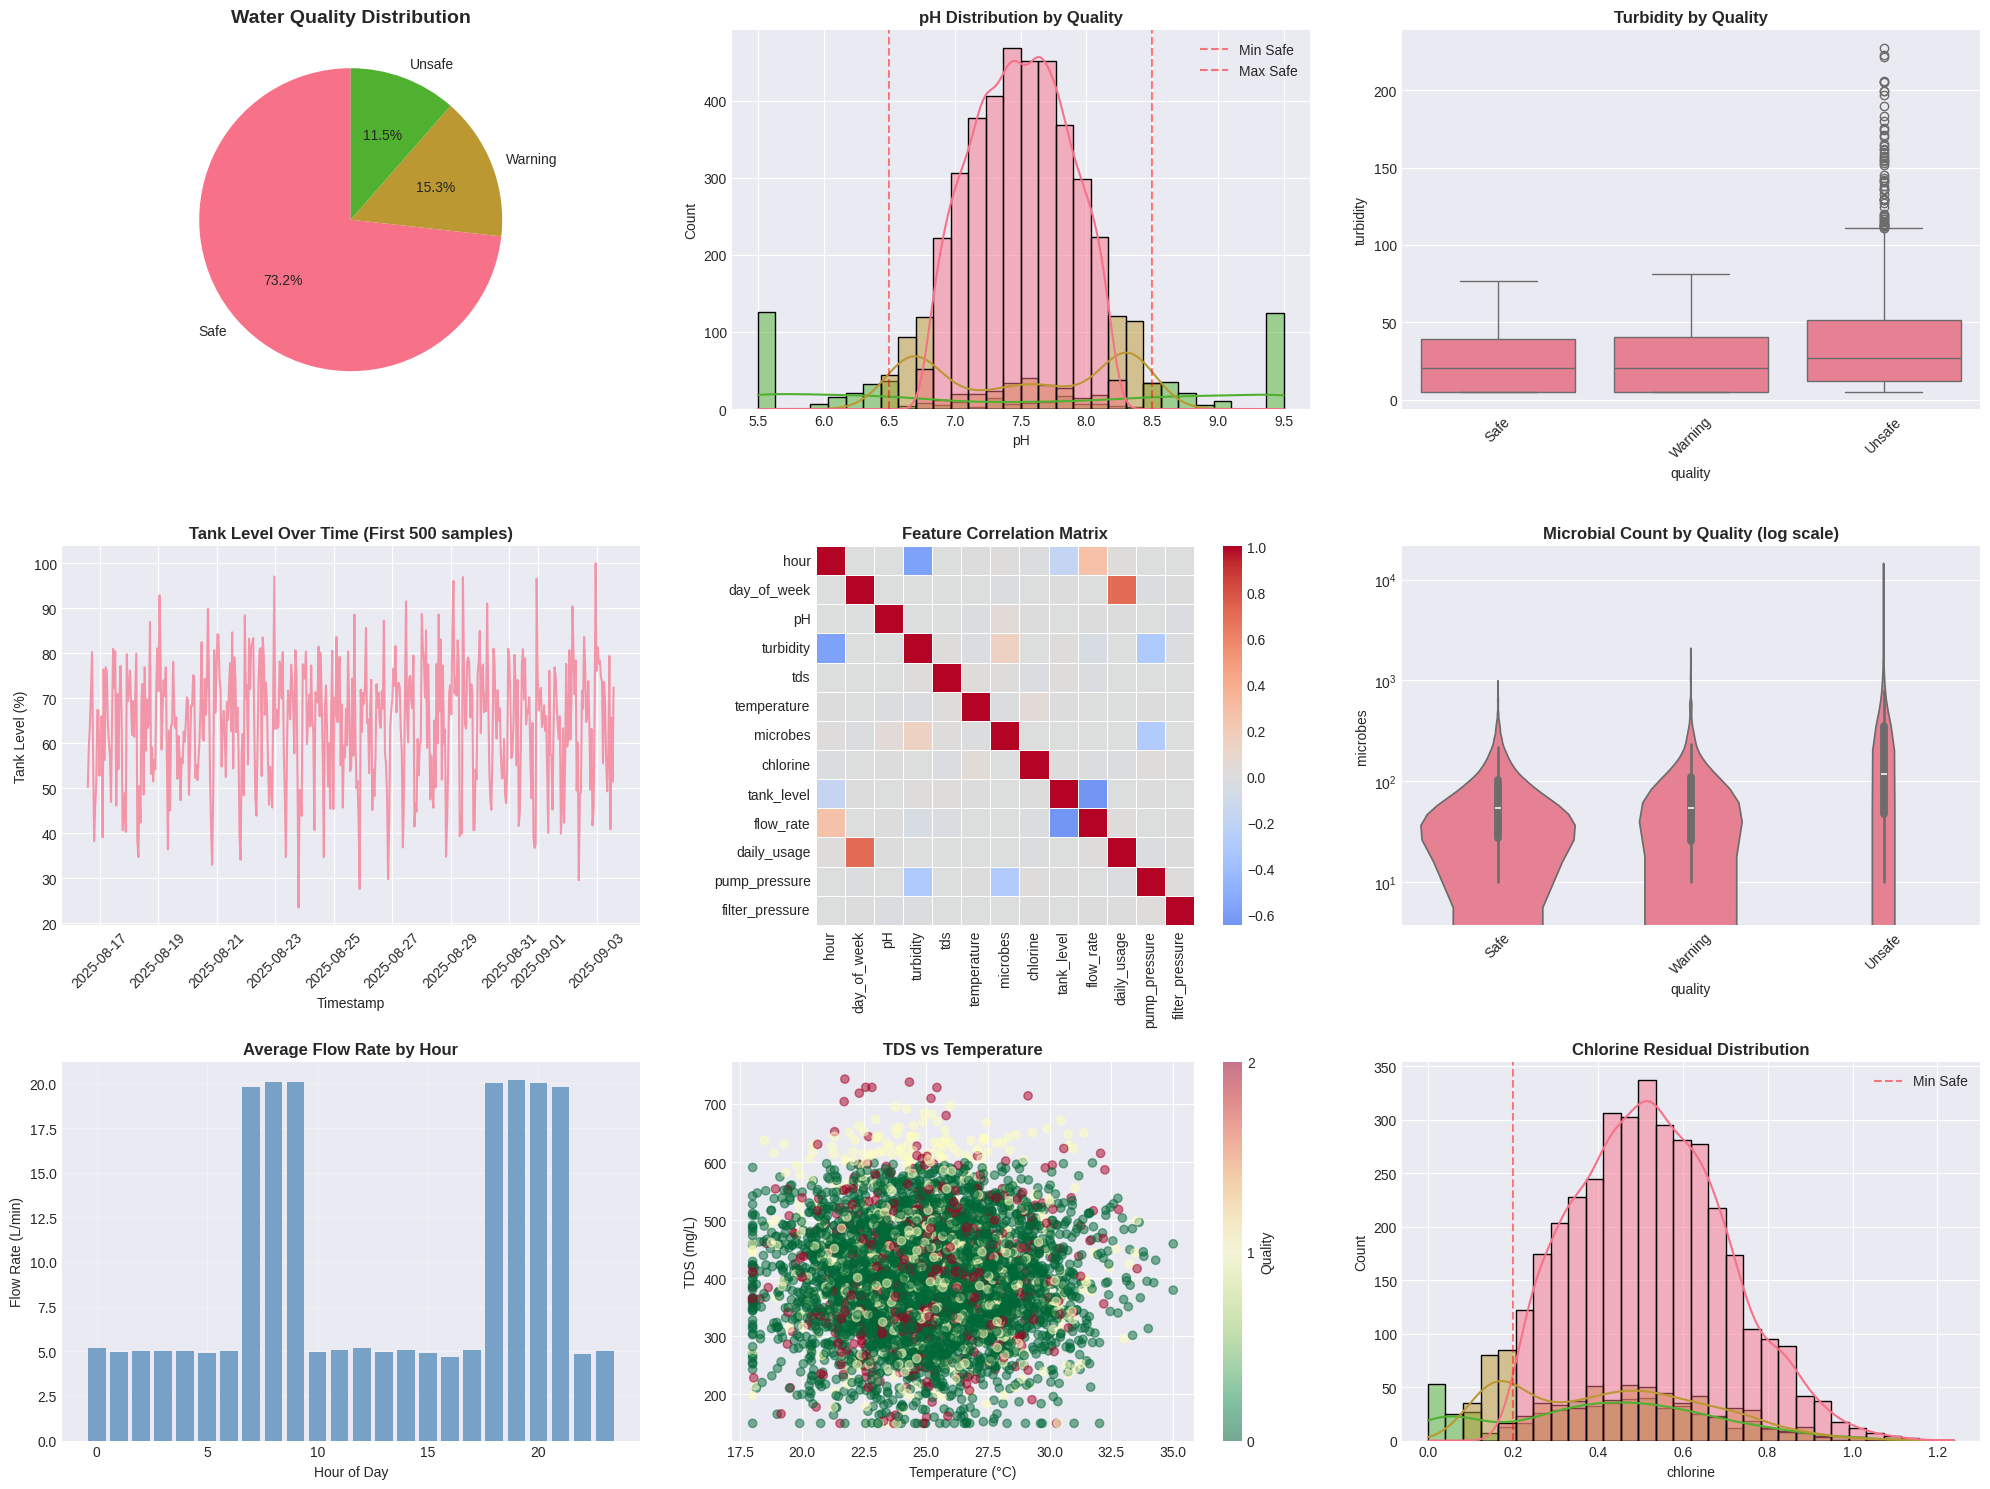


✓ EDA visualizations saved as 'eda_analysis.png'

DATA PREPROCESSING & FEATURE ENGINEERING

🔧 Handling missing values...
✓ Missing values handled. Remaining nulls: 0

🛠️ Engineering new features...
✓ Created 16 new features
✓ Total features now: 31

✅ Validating physical ranges...
✓ pH: All values in valid range
✓ turbidity: All values in valid range
✓ tds: All values in valid range
✓ temperature: All values in valid range
✓ microbes: All values in valid range
✓ chlorine: All values in valid range
✓ tank_level: All values in valid range
✓ flow_rate: All values in valid range
✓ pump_pressure: All values in valid range
✓ filter_pressure: All values in valid range

✓ Processed dataset saved as 'greywater_processed_data.csv'

MODEL A: WATER QUALITY CLASSIFICATION

📊 Features: 28
📊 Classes: ['Safe' 'Unsafe' 'Warning']
📊 Class distribution: [3662  573  765]

✓ Train set: 4000 samples
✓ Test set: 1000 samples

🔄 Training Random Forest...

✓ Random Forest Results:
  Train Accuracy: 0.9995
  T

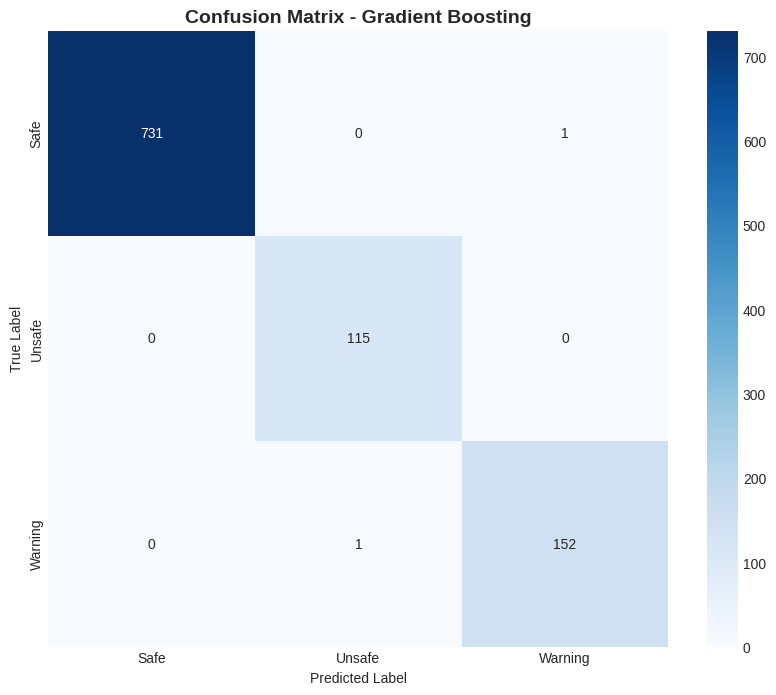

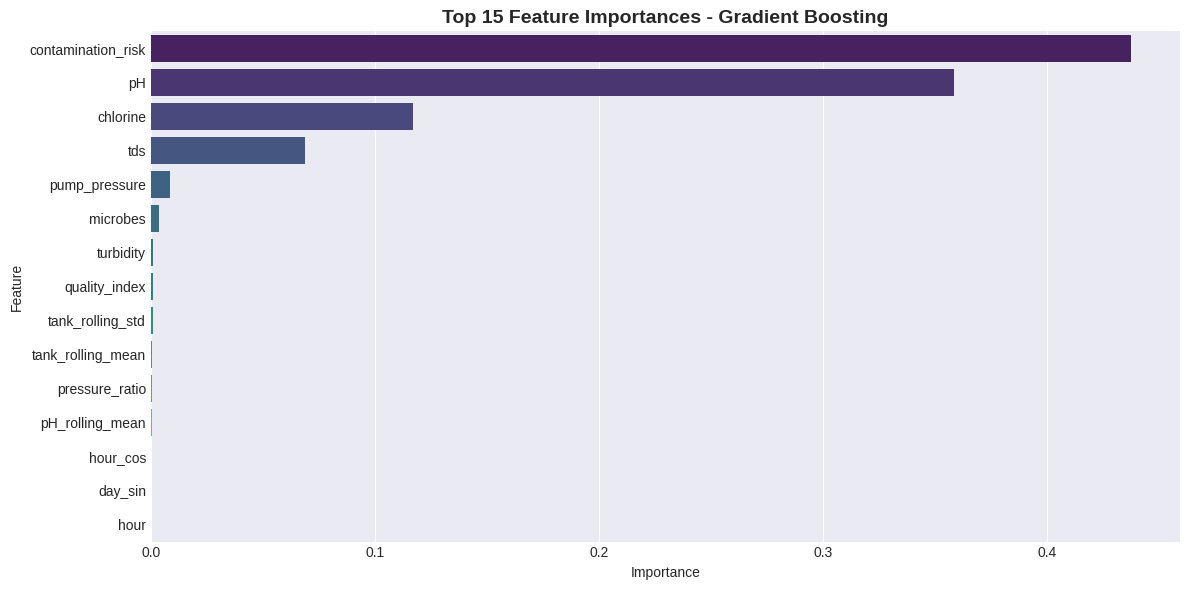


📊 Top 10 Important Features:
               feature  importance
27  contamination_risk    0.437608
2                   pH    0.358720
7             chlorine    0.117117
4                  tds    0.069021
10       pump_pressure    0.008615
6             microbes    0.003715
3            turbidity    0.001027
20       quality_index    0.000933
17    tank_rolling_std    0.000898
16   tank_rolling_mean    0.000620

✓ Model artifacts saved:
  - quality_classifier.pkl
  - quality_scaler.pkl
  - quality_label_encoder.pkl
  - quality_feature_cols.pkl

MODEL B: DEMAND & STORAGE FORECASTING

📊 Features: 27

✓ Train set: 4000 samples
✓ Test set: 1000 samples

--------------------------------------------------------------------------------
TANK LEVEL PREDICTION
--------------------------------------------------------------------------------

🔄 Training Random Forest for tank level...

✓ Random Forest Results (Tank Level):
  Train RMSE: 2.6601
  Test RMSE:  6.4548
  Train MAE:  2.0783
  Test MAE: 

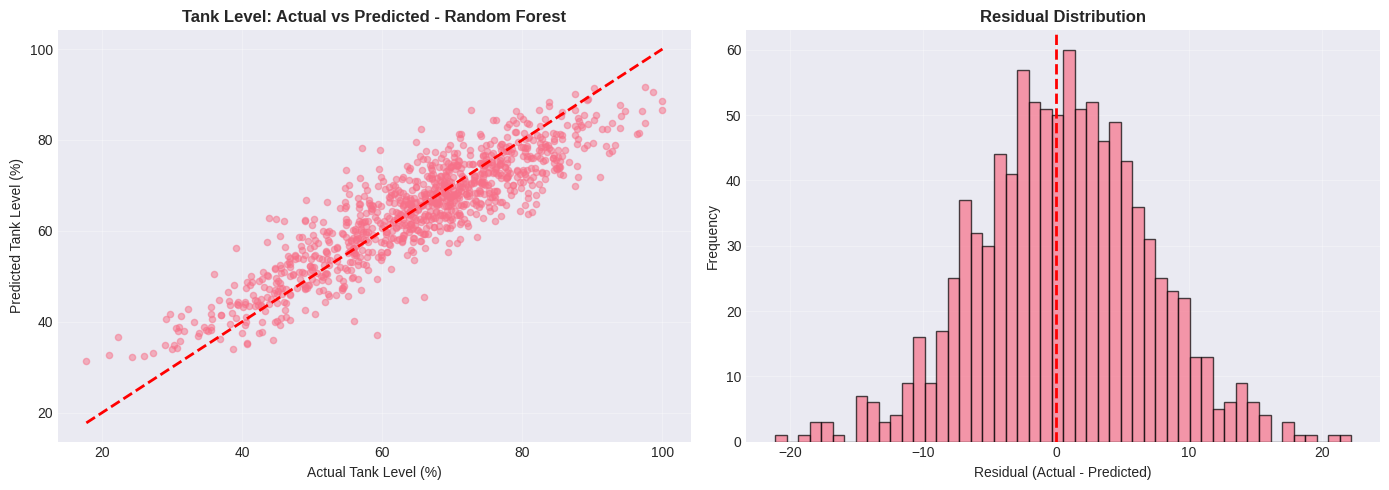


--------------------------------------------------------------------------------
DAILY USAGE PREDICTION
--------------------------------------------------------------------------------

🔄 Training Random Forest for daily usage...

✓ Daily Usage Results:
  Train RMSE: 35.8308
  Test RMSE:  50.6888
  Test MAE:   40.4915
  Test R²:    0.7640
  Test MAPE:  7.49%

✓ Forecasting models saved:
  - tank_level_regressor.pkl
  - usage_regressor.pkl
  - demand_scaler.pkl
  - demand_feature_cols.pkl


In [ ]:
# -*- coding: utf-8 -*-
"""Grey Water Management System.ipynb"""

!pip install -q streamlit gradio shap plotly scikit-learn pandas numpy joblib openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score, mean_squared_error,
                             mean_absolute_error, r2_score)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR

try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    KERAS_AVAILABLE = True
except:
    KERAS_AVAILABLE = False
    print("Keras not available - skipping LSTM forecasting")

import joblib
import pickle
from datetime import datetime, timedelta
import json
import sqlite3

try:
    import shap
    SHAP_AVAILABLE = True
except:
    !pip install -q shap
    import shap
    SHAP_AVAILABLE = True

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All dependencies loaded successfully!")
print(f"✓ SHAP available: {SHAP_AVAILABLE}")
print(f"✓ Keras available: {KERAS_AVAILABLE}")

def generate_greywater_dataset(n_samples=5000, seed=42):
    """
    Generate realistic synthetic grey water monitoring dataset
    """
    np.random.seed(seed)

    # Generate timestamps (last 180 days, hourly readings)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)
    timestamps = pd.date_range(start=start_date, end=end_date, periods=n_samples)

    # Extract time features
    hour = timestamps.hour
    day_of_week = timestamps.dayofweek

    # Base parameters with realistic ranges
    data = {
        'timestamp': timestamps,
        'hour': hour,
        'day_of_week': day_of_week,
    }

    # pH (slightly alkaline grey water: 6.5-8.5, normal around 7.5)
    data['pH'] = np.random.normal(7.5, 0.5, n_samples)
    data['pH'] = np.clip(data['pH'], 6.0, 9.0)

    # Turbidity (NTU) - varies with usage
    base_turbidity = 20 + 30 * np.sin(hour * np.pi / 12)
    data['turbidity'] = base_turbidity + np.random.normal(0, 10, n_samples)
    data['turbidity'] = np.clip(data['turbidity'], 5, 150)

    # TDS (Total Dissolved Solids) - mg/L
    data['tds'] = np.random.normal(400, 100, n_samples)
    data['tds'] = np.clip(data['tds'], 150, 800)

    # Temperature (°C)
    data['temperature'] = np.random.normal(25, 3, n_samples)
    data['temperature'] = np.clip(data['temperature'], 18, 35)

    # Microbial count (CFU/100ml) - log scale
    data['microbes'] = np.random.lognormal(4, 1, n_samples)
    data['microbes'] = np.clip(data['microbes'], 10, 10000)

    # Chlorine residual (mg/L)
    data['chlorine'] = np.random.normal(0.5, 0.2, n_samples)
    data['chlorine'] = np.clip(data['chlorine'], 0, 2)

    # Tank level (%) - influenced by time of day
    peak_hours = ((hour >= 7) & (hour <= 9)) | ((hour >= 18) & (hour <= 21))
    base_level = 70 - 20 * peak_hours.astype(int)
    data['tank_level'] = base_level + np.random.normal(0, 10, n_samples)
    data['tank_level'] = np.clip(data['tank_level'], 10, 100)

    # Flow rate (L/min)
    data['flow_rate'] = 15 * peak_hours.astype(int) + np.random.normal(5, 2, n_samples)
    data['flow_rate'] = np.clip(data['flow_rate'], 0, 30)

    # Daily water usage (L/day) - varies by day of week
    weekend = (day_of_week >= 5).astype(int)
    data['daily_usage'] = 500 + 200 * weekend + np.random.normal(0, 50, n_samples)
    data['daily_usage'] = np.clip(data['daily_usage'], 200, 1000)

    # Pump pressure (PSI)
    data['pump_pressure'] = np.random.normal(40, 5, n_samples)
    data['pump_pressure'] = np.clip(data['pump_pressure'], 20, 60)

    # Filter pressure drop (PSI)
    data['filter_pressure'] = np.random.normal(15, 3, n_samples)
    data['filter_pressure'] = np.clip(data['filter_pressure'], 5, 30)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Introduce anomalies (5% of data)
    n_anomalies = int(0.05 * n_samples)
    anomaly_indices = np.random.choice(df.index, n_anomalies, replace=False)

    df.loc[anomaly_indices, 'pH'] = np.random.choice([5.5, 9.5], n_anomalies)
    df.loc[anomaly_indices, 'turbidity'] *= np.random.uniform(2, 4, n_anomalies)
    df.loc[anomaly_indices, 'microbes'] *= np.random.uniform(5, 10, n_anomalies)
    df.loc[anomaly_indices, 'pump_pressure'] *= np.random.uniform(0.3, 0.5, n_anomalies)

    # Add missing values (2% random)
    for col in ['turbidity', 'tds', 'chlorine', 'flow_rate']:
        missing_idx = np.random.choice(df.index, int(0.02 * n_samples), replace=False)
        df.loc[missing_idx, col] = np.nan

    # Determine water quality classification
    df['quality'] = 'Safe'

    # Warning conditions
    warning_mask = (
        (df['pH'] < 6.8) | (df['pH'] > 8.2) |
        (df['turbidity'] > 80) |
        (df['tds'] > 600) |
        (df['microbes'] > 1000) |
        (df['chlorine'] < 0.2)
    )
    df.loc[warning_mask, 'quality'] = 'Warning'

    # Unsafe conditions
    unsafe_mask = (
        (df['pH'] < 6.5) | (df['pH'] > 8.5) |
        (df['turbidity'] > 120) |
        (df['tds'] > 700) |
        (df['microbes'] > 5000) |
        (df['chlorine'] < 0.1) |
        (df['pump_pressure'] < 25)
    )
    df.loc[unsafe_mask, 'quality'] = 'Unsafe'

    return df

# Generate dataset
print("Generating synthetic grey water dataset...")
df = generate_greywater_dataset(n_samples=5000, seed=42)
print(f"✓ Dataset generated: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nQuality Distribution:\n{df['quality'].value_counts()}")
print(f"\nFirst few rows:")
print(df.head())

# Save raw dataset
df.to_csv('greywater_raw_data.csv', index=False)
print("\n✓ Raw dataset saved as 'greywater_raw_data.csv'")

def perform_eda(df):
    """Comprehensive EDA with visualizations"""

    print("="*80)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*80)

    # Basic statistics
    print("\n📊 Dataset Info:")
    print(df.info())

    print("\n📈 Statistical Summary:")
    print(df.describe())

    print("\n🔍 Missing Values:")
    print(df.isnull().sum())

    # Visualizations
    fig = plt.figure(figsize=(20, 15))

    # 1. Quality distribution
    plt.subplot(3, 3, 1)
    quality_counts = df['quality'].value_counts()
    plt.pie(quality_counts, labels=quality_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Water Quality Distribution', fontsize=14, fontweight='bold')

    # 2. pH distribution
    plt.subplot(3, 3, 2)
    sns.histplot(data=df, x='pH', hue='quality', kde=True, bins=30)
    plt.title('pH Distribution by Quality', fontsize=12, fontweight='bold')
    plt.axvline(x=6.5, color='r', linestyle='--', alpha=0.5, label='Min Safe')
    plt.axvline(x=8.5, color='r', linestyle='--', alpha=0.5, label='Max Safe')
    plt.legend()

    # 3. Turbidity distribution
    plt.subplot(3, 3, 3)
    sns.boxplot(data=df, x='quality', y='turbidity')
    plt.title('Turbidity by Quality', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)

    # 4. Time series - Tank Level
    plt.subplot(3, 3, 4)
    plt.plot(df['timestamp'][:500], df['tank_level'][:500], alpha=0.7)
    plt.title('Tank Level Over Time (First 500 samples)', fontsize=12, fontweight='bold')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level (%)')
    plt.xticks(rotation=45)

    # 5. Correlation heatmap
    plt.subplot(3, 3, 5)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

    # 6. Microbes vs Quality
    plt.subplot(3, 3, 6)
    sns.violinplot(data=df, x='quality', y='microbes')
    plt.yscale('log')
    plt.title('Microbial Count by Quality (log scale)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)

    # 7. Daily usage pattern
    plt.subplot(3, 3, 7)
    hourly_usage = df.groupby('hour')['flow_rate'].mean()
    plt.bar(hourly_usage.index, hourly_usage.values, color='steelblue', alpha=0.7)
    plt.title('Average Flow Rate by Hour', fontsize=12, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Flow Rate (L/min)')
    plt.grid(alpha=0.3)

    # 8. TDS vs Temperature
    plt.subplot(3, 3, 8)
    scatter = plt.scatter(df['temperature'], df['tds'], c=df['quality'].map({'Safe': 0, 'Warning': 1, 'Unsafe': 2}),
                         cmap='RdYlGn_r', alpha=0.5)
    plt.colorbar(scatter, label='Quality', ticks=[0, 1, 2])
    plt.title('TDS vs Temperature', fontsize=12, fontweight='bold')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('TDS (mg/L)')

    # 9. Chlorine levels
    plt.subplot(3, 3, 9)
    sns.histplot(data=df, x='chlorine', hue='quality', kde=True, bins=30)
    plt.title('Chlorine Residual Distribution', fontsize=12, fontweight='bold')
    plt.axvline(x=0.2, color='r', linestyle='--', alpha=0.5, label='Min Safe')
    plt.legend()

    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ EDA visualizations saved as 'eda_analysis.png'")

# Perform EDA
perform_eda(df)

def preprocess_data(df):
    """
    Comprehensive preprocessing and feature engineering
    """
    print("\n" + "="*80)
    print("DATA PREPROCESSING & FEATURE ENGINEERING")
    print("="*80)

    df_processed = df.copy()

    # Handle missing values - FIXED: Using modern pandas methods
    print("\n🔧 Handling missing values...")
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            # Use ffill and bfill without method parameter
            df_processed[col] = df_processed[col].ffill().bfill()
            # Fill any remaining with median
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    print(f"✓ Missing values handled. Remaining nulls: {df_processed.isnull().sum().sum()}")

    # Feature Engineering
    print("\n🛠️ Engineering new features...")

    # 1. Rolling statistics (7-sample window ~7 hours)
    window = 7
    df_processed['pH_rolling_mean'] = df_processed['pH'].rolling(window=window, min_periods=1).mean()
    df_processed['pH_rolling_std'] = df_processed['pH'].rolling(window=window, min_periods=1).std().fillna(0)

    df_processed['turbidity_rolling_mean'] = df_processed['turbidity'].rolling(window=window, min_periods=1).mean()
    df_processed['turbidity_rolling_std'] = df_processed['turbidity'].rolling(window=window, min_periods=1).std().fillna(0)

    df_processed['tank_rolling_mean'] = df_processed['tank_level'].rolling(window=window, min_periods=1).mean()
    df_processed['tank_rolling_std'] = df_processed['tank_level'].rolling(window=window, min_periods=1).std().fillna(0)

    # 2. Peak usage flag
    df_processed['is_peak_hour'] = ((df_processed['hour'] >= 7) & (df_processed['hour'] <= 9) |
                                     (df_processed['hour'] >= 18) & (df_processed['hour'] <= 21)).astype(int)

    # 3. Weekend flag
    df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)

    # 4. Water quality index (composite score)
    df_processed['quality_index'] = (
        (df_processed['pH'] - 7.5).abs() * 10 +
        df_processed['turbidity'] / 10 +
        df_processed['tds'] / 100 +
        np.log1p(df_processed['microbes']) +
        (1 - df_processed['chlorine']) * 20
    )

    # 5. Tank level change rate
    df_processed['tank_change_rate'] = df_processed['tank_level'].diff().fillna(0)

    # 6. Pressure ratio (pump vs filter)
    df_processed['pressure_ratio'] = df_processed['pump_pressure'] / (df_processed['filter_pressure'] + 1)

    # 7. Time-based features
    df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24)
    df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24)
    df_processed['day_sin'] = np.sin(2 * np.pi * df_processed['day_of_week'] / 7)
    df_processed['day_cos'] = np.cos(2 * np.pi * df_processed['day_of_week'] / 7)

    # 8. Contamination risk score
    df_processed['contamination_risk'] = (
        ((df_processed['pH'] < 6.5) | (df_processed['pH'] > 8.5)).astype(int) * 3 +
        (df_processed['turbidity'] > 100).astype(int) * 2 +
        (df_processed['microbes'] > 2000).astype(int) * 3 +
        (df_processed['chlorine'] < 0.2).astype(int) * 2
    )

    print(f"✓ Created {len(df_processed.columns) - len(df.columns)} new features")
    print(f"✓ Total features now: {len(df_processed.columns)}")

    # Validate ranges
    print("\n✅ Validating physical ranges...")
    validations = {
        'pH': (0, 14),
        'turbidity': (0, 500),
        'tds': (0, 2000),
        'temperature': (0, 50),
        'microbes': (0, 50000),
        'chlorine': (0, 5),
        'tank_level': (0, 100),
        'flow_rate': (0, 50),
        'pump_pressure': (0, 100),
        'filter_pressure': (0, 50)
    }

    for col, (min_val, max_val) in validations.items():
        invalid = ((df_processed[col] < min_val) | (df_processed[col] > max_val)).sum()
        if invalid > 0:
            print(f"⚠️  {col}: {invalid} values outside range [{min_val}, {max_val}]")
            df_processed[col] = df_processed[col].clip(min_val, max_val)
        else:
            print(f"✓ {col}: All values in valid range")

    return df_processed

# Preprocess data
df_processed = preprocess_data(df)
df_processed.to_csv('greywater_processed_data.csv', index=False)
print("\n✓ Processed dataset saved as 'greywater_processed_data.csv'")

def train_quality_classifier(df):
    """
    Train multiple classifiers for water quality prediction
    """
    print("\n" + "="*80)
    print("MODEL A: WATER QUALITY CLASSIFICATION")
    print("="*80)

    # Prepare features and target
    feature_cols = [col for col in df.columns if col not in
                    ['timestamp', 'quality', 'daily_usage']]

    X = df[feature_cols].copy()
    y = df['quality'].copy()

    # Encode target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    print(f"\n📊 Features: {len(feature_cols)}")
    print(f"📊 Classes: {le.classes_}")
    print(f"📊 Class distribution: {np.bincount(y_encoded)}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\n✓ Train set: {X_train.shape[0]} samples")
    print(f"✓ Test set: {X_test.shape[0]} samples")

    # Train models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15,
                                                 min_samples_split=5, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, max_depth=10,
                                                         learning_rate=0.1, random_state=42)
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\n🔄 Training {name}...")
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Metrics
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        f1 = f1_score(y_test, y_pred_test, average='weighted')
        precision = precision_score(y_test, y_pred_test, average='weighted')
        recall = recall_score(y_test, y_pred_test, average='weighted')

        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

        results[name] = {
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }

        trained_models[name] = model

        print(f"\n✓ {name} Results:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")
        print(f"  F1 Score:       {f1:.4f}")
        print(f"  Precision:      {precision:.4f}")
        print(f"  Recall:         {recall:.4f}")
        print(f"  CV Accuracy:    {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Select best model
    best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
    best_model = trained_models[best_model_name]

    print(f"\n🏆 Best Model: {best_model_name}")

    # Detailed evaluation of best model
    y_pred_best = best_model.predict(X_test_scaled)

    print(f"\n📋 Classification Report ({best_model_name}):")
    print(classification_report(y_test, y_pred_best, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_quality.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature Importance
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)

        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
        plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig('feature_importance_quality.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n📊 Top 10 Important Features:")
        print(importance_df.head(10))

    # Save artifacts
    joblib.dump(best_model, 'quality_classifier.pkl')
    joblib.dump(scaler, 'quality_scaler.pkl')
    joblib.dump(le, 'quality_label_encoder.pkl')

    with open('quality_feature_cols.pkl', 'wb') as f:
        pickle.dump(feature_cols, f)

    print("\n✓ Model artifacts saved:")
    print("  - quality_classifier.pkl")
    print("  - quality_scaler.pkl")
    print("  - quality_label_encoder.pkl")
    print("  - quality_feature_cols.pkl")

    return best_model, scaler, le, feature_cols, results

# Train quality classifier
quality_model, quality_scaler, quality_le, quality_features, quality_results = train_quality_classifier(df_processed)

def train_demand_forecaster(df):
    """
    Train regression models for tank level and usage forecasting
    """
    print("\n" + "="*80)
    print("MODEL B: DEMAND & STORAGE FORECASTING")
    print("="*80)

    # Prepare features for tank level prediction
    feature_cols = [col for col in df.columns if col not in
                    ['timestamp', 'quality', 'tank_level', 'daily_usage']]

    X = df[feature_cols].copy()
    y_tank = df['tank_level'].copy()
    y_usage = df['daily_usage'].copy()

    print(f"\n📊 Features: {len(feature_cols)}")

    # Train-test split
    X_train, X_test, y_tank_train, y_tank_test, y_usage_train, y_usage_test = train_test_split(
        X, y_tank, y_usage, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\n✓ Train set: {X_train.shape[0]} samples")
    print(f"✓ Test set: {X_test.shape[0]} samples")

    # --- TANK LEVEL PREDICTION ---
    print("\n" + "-"*80)
    print("TANK LEVEL PREDICTION")
    print("-"*80)

    # FIXED: Changed GradientBoostingClassifier to GradientBoostingRegressor
    tank_models = {
        'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15,
                                               min_samples_split=5, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=150, max_depth=10,
                                                        learning_rate=0.1, random_state=42)
    }

    tank_results = {}
    trained_tank_models = {}

    for name, model in tank_models.items():
        print(f"\n🔄 Training {name} for tank level...")

        model.fit(X_train_scaled, y_tank_train)

        # Predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_tank_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_tank_test, y_pred_test))
        train_mae = mean_absolute_error(y_tank_train, y_pred_train)
        test_mae = mean_absolute_error(y_tank_test, y_pred_test)
        train_r2 = r2_score(y_tank_train, y_pred_train)
        test_r2 = r2_score(y_tank_test, y_pred_test)
        # MAPE
        mape_train = np.mean(np.abs((y_tank_train - y_pred_train) / (y_tank_train + 1))) * 100
        mape_test = np.mean(np.abs((y_tank_test - y_pred_test) / (y_tank_test + 1))) * 100

        tank_results[name] = {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mape': mape_train,
            'test_mape': mape_test
        }

        trained_tank_models[name] = model

        print(f"\n✓ {name} Results (Tank Level):")
        print(f"  Train RMSE: {train_rmse:.4f}")
        print(f"  Test RMSE:  {test_rmse:.4f}")
        print(f"  Train MAE:  {train_mae:.4f}")
        print(f"  Test MAE:   {test_mae:.4f}")
        print(f"  Train R²:   {train_r2:.4f}")
        print(f"  Test R²:    {test_r2:.4f}")
        print(f"  Train MAPE: {mape_train:.2f}%")
        print(f"  Test MAPE:  {mape_test:.2f}%")

    # Select best tank model
    best_tank_name = min(tank_results, key=lambda x: tank_results[x]['test_rmse'])
    best_tank_model = trained_tank_models[best_tank_name]

    print(f"\n🏆 Best Tank Level Model: {best_tank_name}")

    # Visualization - Actual vs Predicted (Tank Level)
    y_tank_pred = best_tank_model.predict(X_test_scaled)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_tank_test, y_tank_pred, alpha=0.5, s=20)
    plt.plot([y_tank_test.min(), y_tank_test.max()],
             [y_tank_test.min(), y_tank_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Tank Level (%)')
    plt.ylabel('Predicted Tank Level (%)')
    plt.title(f'Tank Level: Actual vs Predicted - {best_tank_name}', fontweight='bold')
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    residuals = y_tank_test - y_tank_pred
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution', fontweight='bold')
    plt.axvline(x=0, color='r', linestyle='--', lw=2)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('tank_level_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- DAILY USAGE PREDICTION ---
    print("\n" + "-"*80)
    print("DAILY USAGE PREDICTION")
    print("-"*80)

    usage_model = RandomForestRegressor(n_estimators=150, max_depth=12,
                                        min_samples_split=5, random_state=42, n_jobs=-1)

    print(f"\n🔄 Training Random Forest for daily usage...")
    usage_model.fit(X_train_scaled, y_usage_train)

    # Predictions
    y_usage_pred_train = usage_model.predict(X_train_scaled)
    y_usage_pred_test = usage_model.predict(X_test_scaled)

    # Metrics
    usage_rmse_train = np.sqrt(mean_squared_error(y_usage_train, y_usage_pred_train))
    usage_rmse_test = np.sqrt(mean_squared_error(y_usage_test, y_usage_pred_test))
    usage_mae_test = mean_absolute_error(y_usage_test, y_usage_pred_test)
    usage_r2_test = r2_score(y_usage_test, y_usage_pred_test)
    usage_mape_test = np.mean(np.abs((y_usage_test - y_usage_pred_test) / (y_usage_test + 1))) * 100

    print(f"\n✓ Daily Usage Results:")
    print(f"  Train RMSE: {usage_rmse_train:.4f}")
    print(f"  Test RMSE:  {usage_rmse_test:.4f}")
    print(f"  Test MAE:   {usage_mae_test:.4f}")
    print(f"  Test R²:    {usage_r2_test:.4f}")
    print(f"  Test MAPE:  {usage_mape_test:.2f}%")

    # Save models
    joblib.dump(best_tank_model, 'tank_level_regressor.pkl')
    joblib.dump(usage_model, 'usage_regressor.pkl')
    joblib.dump(scaler, 'demand_scaler.pkl')

    with open('demand_feature_cols.pkl', 'wb') as f:
        pickle.dump(feature_cols, f)

    print("\n✓ Forecasting models saved:")
    print("  - tank_level_regressor.pkl")
    print("  - usage_regressor.pkl")
    print("  - demand_scaler.pkl")
    print("  - demand_feature_cols.pkl")

    return best_tank_model, usage_model, scaler, feature_cols, tank_results

tank_model, usage_model, demand_scaler, demand_features, tank_results = train_demand_forecaster(df_processed)


MODEL C: ANOMALY & FAILURE DETECTION

📊 Features: 28

🔄 Training Isolation Forest...

✓ Anomalies detected: 250 (5.00%)

📊 Anomalies by Water Quality:
         Anomalies  Total       Rate
quality                             
Safe            10   3662   0.273075
Unsafe         231    573  40.314136
Warning          9    765   1.176471

🔍 Anomaly Characteristics:
  Avg pH: 7.59 (Normal: 7.49)
  Avg Turbidity: 69.26 (Normal: 23.83)
  Avg Microbes: 593.92 (Normal: 87.43)
  Avg Pump Pressure: 19.35 (Normal: 39.79)


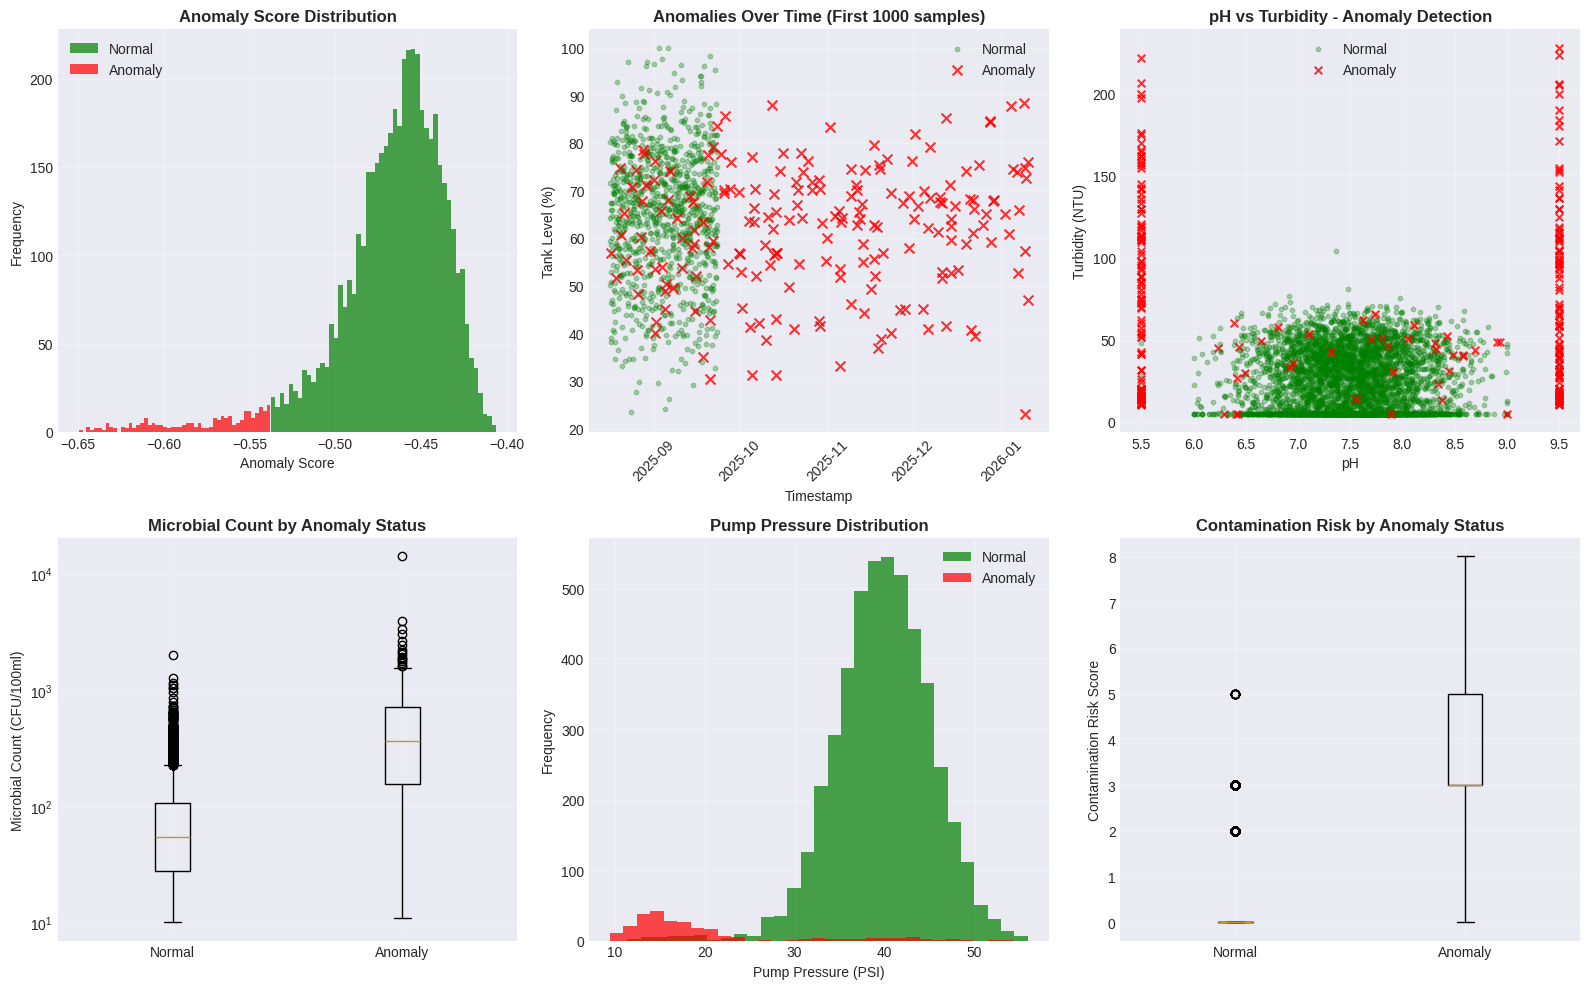


✓ Anomaly detection models saved:
  - anomaly_detector.pkl
  - anomaly_scaler.pkl
  - anomaly_feature_cols.pkl


In [ ]:
def train_anomaly_detector(df):
    """
    Train Isolation Forest for anomaly and equipment failure detection
    """
    print("\n" + "="*80)
    print("MODEL C: ANOMALY & FAILURE DETECTION")
    print("="*80)
    # Prepare features
    feature_cols = [col for col in df.columns if col not in
                    ['timestamp', 'quality', 'daily_usage']]

    X = df[feature_cols].copy()

    print(f"\n📊 Features: {len(feature_cols)}")

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train Isolation Forest
    print("\n🔄 Training Isolation Forest...")
    iso_forest = IsolationForest(
        n_estimators=200,
        contamination=0.05,  # Expected 5% anomalies
        max_samples='auto',
        random_state=42,
        n_jobs=-1
    )

    iso_forest.fit(X_scaled)

    # Predict anomalies
    anomaly_pred = iso_forest.predict(X_scaled)
    anomaly_scores = iso_forest.score_samples(X_scaled)

    # Convert predictions (-1 for anomaly, 1 for normal)
    df['is_anomaly'] = (anomaly_pred == -1).astype(int)
    df['anomaly_score'] = anomaly_scores

    n_anomalies = df['is_anomaly'].sum()
    anomaly_rate = (n_anomalies / len(df)) * 100

    print(f"\n✓ Anomalies detected: {n_anomalies} ({anomaly_rate:.2f}%)")

    # Analyze anomalies by quality
    anomaly_by_quality = df.groupby('quality')['is_anomaly'].agg(['sum', 'count', 'mean'])
    anomaly_by_quality.columns = ['Anomalies', 'Total', 'Rate']
    anomaly_by_quality['Rate'] = anomaly_by_quality['Rate'] * 100

    print(f"\n📊 Anomalies by Water Quality:")
    print(anomaly_by_quality)

    # Identify specific failure types
    anomalies_df = df[df['is_anomaly'] == 1].copy()

    print(f"\n🔍 Anomaly Characteristics:")
    print(f"  Avg pH: {anomalies_df['pH'].mean():.2f} (Normal: {df[df['is_anomaly']==0]['pH'].mean():.2f})")
    print(f"  Avg Turbidity: {anomalies_df['turbidity'].mean():.2f} (Normal: {df[df['is_anomaly']==0]['turbidity'].mean():.2f})")
    print(f"  Avg Microbes: {anomalies_df['microbes'].mean():.2f} (Normal: {df[df['is_anomaly']==0]['microbes'].mean():.2f})")
    print(f"  Avg Pump Pressure: {anomalies_df['pump_pressure'].mean():.2f} (Normal: {df[df['is_anomaly']==0]['pump_pressure'].mean():.2f})")

    # Visualizations
    fig = plt.figure(figsize=(16, 10))

    # 1. Anomaly score distribution
    plt.subplot(2, 3, 1)
    plt.hist(df[df['is_anomaly']==0]['anomaly_score'], bins=50, alpha=0.7, label='Normal', color='green')
    plt.hist(df[df['is_anomaly']==1]['anomaly_score'], bins=50, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Anomaly Score Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    # 2. Anomalies over time
    plt.subplot(2, 3, 2)
    plt.scatter(df[df['is_anomaly']==0]['timestamp'][:1000],
                df[df['is_anomaly']==0]['tank_level'][:1000],
                c='green', alpha=0.3, s=10, label='Normal')
    anomaly_subset = df[df['is_anomaly']==1].head(200)
    plt.scatter(anomaly_subset['timestamp'], anomaly_subset['tank_level'],
                c='red', alpha=0.8, s=50, marker='x', label='Anomaly')
    plt.xlabel('Timestamp')
    plt.ylabel('Tank Level (%)')
    plt.title('Anomalies Over Time (First 1000 samples)', fontweight='bold')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)

    # 3. pH vs Turbidity with anomalies
    plt.subplot(2, 3, 3)
    plt.scatter(df[df['is_anomaly']==0]['pH'],
                df[df['is_anomaly']==0]['turbidity'],
                c='green', alpha=0.3, s=10, label='Normal')
    plt.scatter(df[df['is_anomaly']==1]['pH'],
                df[df['is_anomaly']==1]['turbidity'],
                c='red', alpha=0.8, s=30, marker='x', label='Anomaly')
    plt.xlabel('pH')
    plt.ylabel('Turbidity (NTU)')
    plt.title('pH vs Turbidity - Anomaly Detection', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    # 4. Microbes distribution
    plt.subplot(2, 3, 4)
    plt.boxplot([df[df['is_anomaly']==0]['microbes'],
                 df[df['is_anomaly']==1]['microbes']],
                labels=['Normal', 'Anomaly'])
    plt.ylabel('Microbial Count (CFU/100ml)')
    plt.title('Microbial Count by Anomaly Status', fontweight='bold')
    plt.yscale('log')
    plt.grid(alpha=0.3)

    # 5. Pump pressure
    plt.subplot(2, 3, 5)
    plt.hist(df[df['is_anomaly']==0]['pump_pressure'], bins=30, alpha=0.7, label='Normal', color='green')
    plt.hist(df[df['is_anomaly']==1]['pump_pressure'], bins=30, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel('Pump Pressure (PSI)')
    plt.ylabel('Frequency')
    plt.title('Pump Pressure Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    # 6. Contamination risk score
    plt.subplot(2, 3, 6)
    plt.boxplot([df[df['is_anomaly']==0]['contamination_risk'],
                 df[df['is_anomaly']==1]['contamination_risk']],
                labels=['Normal', 'Anomaly'])
    plt.ylabel('Contamination Risk Score')
    plt.title('Contamination Risk by Anomaly Status', fontweight='bold')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('anomaly_detection_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save model
    joblib.dump(iso_forest, 'anomaly_detector.pkl')
    joblib.dump(scaler, 'anomaly_scaler.pkl')

    with open('anomaly_feature_cols.pkl', 'wb') as f:
        pickle.dump(feature_cols, f)

    print("\n✓ Anomaly detection models saved:")
    print("  - anomaly_detector.pkl")
    print("  - anomaly_scaler.pkl")
    print("  - anomaly_feature_cols.pkl")

    return iso_forest, scaler, feature_cols

anomaly_model, anomaly_scaler, anomaly_features = train_anomaly_detector(df_processed)

In [ ]:
if SHAP_AVAILABLE:
    print("\n" + "="*80)
    print("MODEL EXPLAINABILITY - SHAP ANALYSIS")
    print("="*80)
    try:
        # Prepare data for SHAP
        feature_cols = quality_features
        X_sample = df_processed[feature_cols].sample(500, random_state=42)
        X_sample_scaled = quality_scaler.transform(X_sample)

        print("\n🔄 Computing SHAP values for Quality Classifier...")
        print("   (This may take a few minutes...)")

        # Create SHAP explainer
        explainer = shap.TreeExplainer(quality_model)
        shap_values = explainer.shap_values(X_sample_scaled)

        # Summary plot
        plt.figure(figsize=(12, 8))

        if isinstance(shap_values, list):  # Multi-class
            shap.summary_plot(shap_values[1], X_sample, feature_names=feature_cols,
                              show=False, max_display=15)
        else:
            shap.summary_plot(shap_values, X_sample, feature_names=feature_cols,
                              show=False, max_display=15)

        plt.title('SHAP Feature Importance - Quality Classification',
                  fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ SHAP analysis complete and saved as 'shap_summary.png'")

    except Exception as e:
        print(f"⚠️  SHAP analysis skipped due to error: {e}")


MODEL EXPLAINABILITY - SHAP ANALYSIS

🔄 Computing SHAP values for Quality Classifier...
   (This may take a few minutes...)
⚠️  SHAP analysis skipped due to error: GradientBoostingClassifier is only supported for binary classification right now!


In [ ]:
def generate_recommendations(quality, tank_level, anomaly_detected,
                             pH, turbidity, microbes, chlorine, pump_pressure):
    """
    Generate actionable recommendations based on predictions
    """
    recommendations = []
    # Quality-based recommendations
    if quality == 'Unsafe':
        recommendations.append("⛔ CRITICAL: Water is UNSAFE for reuse. Immediate action required.")
        recommendations.append("🔴 Do NOT use this water for any purpose until treated.")
    elif quality == 'Warning':
        recommendations.append("⚠️  WARNING: Water quality is marginal. Use with caution.")
        recommendations.append("🟡 Consider additional treatment before reuse.")
    else:
        recommendations.append("✅ Water quality is SAFE for reuse (irrigation, toilet flushing, etc.).")

    # pH recommendations
    if pH < 6.5:
        recommendations.append(f"🔧 pH is too low ({pH:.2f}). Add alkaline buffer or soda ash.")
    elif pH > 8.5:
        recommendations.append(f"🔧 pH is too high ({pH:.2f}). Add acid or vinegar to lower pH.")

    # Turbidity recommendations
    if turbidity > 100:
        recommendations.append(f"🔧 High turbidity ({turbidity:.1f} NTU). Check and clean filters immediately.")
    elif turbidity > 80:
        recommendations.append(f"🔧 Elevated turbidity ({turbidity:.1f} NTU). Schedule filter maintenance soon.")

    # Microbial recommendations
    if microbes > 5000:
        recommendations.append(f"🦠 CRITICAL: High microbial count ({microbes:.0f} CFU/100ml). Increase chlorination immediately.")
    elif microbes > 2000:
        recommendations.append(f"🦠 Elevated microbial count ({microbes:.0f} CFU/100ml). Monitor chlorine levels closely.")

    # Chlorine recommendations
    if chlorine < 0.2:
        recommendations.append(f"💊 Low chlorine residual ({chlorine:.2f} mg/L). Add chlorine to maintain 0.5-1.0 mg/L.")
    elif chlorine > 1.5:
        recommendations.append(f"💊 High chlorine ({chlorine:.2f} mg/L). Reduce dosing to avoid corrosion.")

    # Tank level recommendations
    if tank_level < 20:
        recommendations.append(f"📉 LOW TANK LEVEL ({tank_level:.1f}%). Reduce usage or increase grey water collection.")
    elif tank_level > 90:
        recommendations.append(f"📈 HIGH TANK LEVEL ({tank_level:.1f}%). Increase reuse or check for overflow risks.")

    # Pump pressure recommendations
    if pump_pressure < 25:
        recommendations.append(f"⚙️  LOW PUMP PRESSURE ({pump_pressure:.1f} PSI). Check for pump failure or leaks.")
    elif pump_pressure > 55:
        recommendations.append(f"⚙️  HIGH PUMP PRESSURE ({pump_pressure:.1f} PSI). Check for blockages or valve issues.")

    # Anomaly recommendations
    if anomaly_detected:
        recommendations.append("🚨 ANOMALY DETECTED! System parameters are unusual.")
        recommendations.append("🔍 Inspect equipment for failures or contamination immediately.")

    # General maintenance
    if len(recommendations) == 1:  # Only safe quality message
        recommendations.append("✨ System operating normally. Perform routine maintenance as scheduled.")

    return recommendations

sample_row = df_processed.iloc[100]
test_recs = generate_recommendations(
    quality='Warning',
    tank_level=sample_row['tank_level'],
    anomaly_detected=True,
    pH=sample_row['pH'],
    turbidity=sample_row['turbidity'],
    microbes=sample_row['microbes'],
    chlorine=sample_row['chlorine'],
    pump_pressure=sample_row['pump_pressure']
)
print("\n" + "="*80)
print("RECOMMENDATION SYSTEM TEST")
print("="*80)
print("\nSample Recommendations:")
for rec in test_recs:
    print(f"  {rec}")

def predict_full_system(input_data):
    """
    Complete prediction pipeline for new data
    """
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()

    # Feature engineering (simplified version)
    if 'hour' in input_df.columns:
        input_df['is_peak_hour'] = ((input_df['hour'] >= 7) & (input_df['hour'] <= 9) |
                                    (input_df['hour'] >= 18) & (input_df['hour'] <= 21)).astype(int)
        input_df['is_weekend'] = (input_df['day_of_week'] >= 5).astype(int)
        input_df['hour_sin'] = np.sin(2 * np.pi * input_df['hour'] / 24)
        input_df['hour_cos'] = np.cos(2 * np.pi * input_df['hour'] / 24)
        input_df['day_sin'] = np.sin(2 * np.pi * input_df['day_of_week'] / 7)
        input_df['day_cos'] = np.cos(2 * np.pi * input_df['day_of_week'] / 7)

    # Add rolling features (use current values as approximation)
    if 'pH' in input_df.columns:
        input_df['pH_rolling_mean'] = input_df['pH']
        input_df['pH_rolling_std'] = 0
    if 'turbidity' in input_df.columns:
        input_df['turbidity_rolling_mean'] = input_df['turbidity']
        input_df['turbidity_rolling_std'] = 0
    if 'tank_level' in input_df.columns:
        input_df['tank_rolling_mean'] = input_df['tank_level']
        input_df['tank_rolling_std'] = 0

    # Add derived features
    if 'tank_level' in input_df.columns:
        input_df['tank_change_rate'] = 0

    if 'pump_pressure' in input_df.columns and 'filter_pressure' in input_df.columns:
        input_df['pressure_ratio'] = input_df['pump_pressure'] / (input_df['filter_pressure'] + 1)

    if all(col in input_df.columns for col in ['pH', 'turbidity', 'tds', 'microbes', 'chlorine']):
        input_df['quality_index'] = (
            (input_df['pH'] - 7.5).abs() * 10 +
            input_df['turbidity'] / 10 +
            input_df['tds'] / 100 +
            np.log1p(input_df['microbes']) +
            (1 - input_df['chlorine']) * 20
        )

        input_df['contamination_risk'] = (
            ((input_df['pH'] < 6.5) | (input_df['pH'] > 8.5)).astype(int) * 3 +
            (input_df['turbidity'] > 100).astype(int) * 2 +
            (input_df['microbes'] > 2000).astype(int) * 3 +
            (input_df['chlorine'] < 0.2).astype(int) * 2
        )

    results = {}

    # Quality Classification
    try:
        X_quality = input_df[quality_features]
        X_quality_scaled = quality_scaler.transform(X_quality)
        quality_pred = quality_model.predict(X_quality_scaled)
        quality_proba = quality_model.predict_proba(X_quality_scaled)

        quality_label = quality_le.inverse_transform(quality_pred)[0]
        confidence = np.max(quality_proba) * 100

        results['quality'] = quality_label
        results['quality_confidence'] = confidence
        results['quality_probabilities'] = {
            cls: prob * 100
            for cls, prob in zip(quality_le.classes_, quality_proba[0])
        }
    except Exception as e:
        results['quality'] = 'Error'
        results['quality_confidence'] = 0
        results['error_quality'] = str(e)

    # Tank Level Forecast
    try:
        X_demand = input_df[demand_features]
        X_demand_scaled = demand_scaler.transform(X_demand)
        tank_pred = tank_model.predict(X_demand_scaled)[0]
        usage_pred = usage_model.predict(X_demand_scaled)[0]

        results['predicted_tank_level'] = tank_pred
        results['predicted_daily_usage'] = usage_pred
    except Exception as e:
        results['predicted_tank_level'] = 'Error'
        results['predicted_daily_usage'] = 'Error'
        results['error_demand'] = str(e)

    # Anomaly Detection
    try:
        X_anomaly = input_df[anomaly_features]
        X_anomaly_scaled = anomaly_scaler.transform(X_anomaly)
        anomaly_pred = anomaly_model.predict(X_anomaly_scaled)
        anomaly_score = anomaly_model.score_samples(X_anomaly_scaled)[0]

        results['anomaly_detected'] = (anomaly_pred[0] == -1)
        results['anomaly_score'] = anomaly_score
    except Exception as e:
        results['anomaly_detected'] = False
        results['anomaly_score'] = 0
        results['error_anomaly'] = str(e)

    # Generate Recommendations
    results['recommendations'] = generate_recommendations(
        quality=results.get('quality', 'Unknown'),
        tank_level=input_df['tank_level'].values[0] if 'tank_level' in input_df else 50,
        anomaly_detected=results.get('anomaly_detected', False),
        pH=input_df['pH'].values[0] if 'pH' in input_df else 7.5,
        turbidity=input_df['turbidity'].values[0] if 'turbidity' in input_df else 50,
        microbes=input_df['microbes'].values[0] if 'microbes' in input_df else 500,
        chlorine=input_df['chlorine'].values[0] if 'chlorine' in input_df else 0.5,
        pump_pressure=input_df['pump_pressure'].values[0] if 'pump_pressure' in input_df else 40
    )

    return results


RECOMMENDATION SYSTEM TEST

Sample Recommendations:
  ⚠️  WARNING: Water quality is marginal. Use with caution.
  🟡 Consider additional treatment before reuse.
  🚨 ANOMALY DETECTED! System parameters are unusual.
  🔍 Inspect equipment for failures or contamination immediately.


In [ ]:
test_input = {
    'pH': 7.2,
    'turbidity': 65,
    'tds': 420,
    'temperature': 24,
    'microbes': 800,
    'chlorine': 0.4,
    'tank_level': 55,
    'flow_rate': 12,
    'pump_pressure': 38,
    'filter_pressure': 16,
    'hour': 14,
    'day_of_week': 2,
    'daily_usage': 550
}

print("\n" + "="*80)
print("FULL SYSTEM PREDICTION TEST")
print("="*80)

test_results = predict_full_system(test_input)

print("\n📊 Input Parameters:")
for key, value in test_input.items():
    print(f"  {key}: {value}")

print("\n🔮 Predictions:")
print(f"  Water Quality: {test_results.get('quality', 'N/A')} "
      f"({test_results.get('quality_confidence', 0):.1f}% confidence)")
print(f"  Predicted Tank Level: {test_results.get('predicted_tank_level', 'N/A')}")
print(f"  Predicted Daily Usage: {test_results.get('predicted_daily_usage', 'N/A')}")
print(f"  Anomaly Detected: {test_results.get('anomaly_detected', False)}")

print("\n💡 Recommendations:")
for rec in test_results.get('recommendations', []):
    print(f"  {rec}")


def setup_logging_database():
    """Create SQLite database for logging predictions"""
    conn = sqlite3.connect('greywater_predictions.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS predictions (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
            pH REAL,
            turbidity REAL,
            tds REAL,
            temperature REAL,
            microbes REAL,
            chlorine REAL,
            tank_level REAL,
            flow_rate REAL,
            pump_pressure REAL,
            filter_pressure REAL,
            predicted_quality TEXT,
            quality_confidence REAL,
            predicted_tank_level REAL,
            predicted_usage REAL,
            anomaly_detected INTEGER,
            anomaly_score REAL
        )
    ''')
    conn.commit()
    conn.close()
    print("\n✓ Logging database created: 'greywater_predictions.db'")


FULL SYSTEM PREDICTION TEST

📊 Input Parameters:
  pH: 7.2
  turbidity: 65
  tds: 420
  temperature: 24
  microbes: 800
  chlorine: 0.4
  tank_level: 55
  flow_rate: 12
  pump_pressure: 38
  filter_pressure: 16
  hour: 14
  day_of_week: 2
  daily_usage: 550

🔮 Predictions:
  Water Quality: Safe (100.0% confidence)
  Predicted Tank Level: 62.214723166700786
  Predicted Daily Usage: 502.7932089035467
  Anomaly Detected: False

💡 Recommendations:
  ✅ Water quality is SAFE for reuse (irrigation, toilet flushing, etc.).
  ✨ System operating normally. Perform routine maintenance as scheduled.


In [ ]:
def log_prediction(input_data, results):
    """Log prediction to database"""
    conn = sqlite3.connect('greywater_predictions.db')
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO predictions (
            pH, turbidity, tds, temperature, microbes, chlorine,
            tank_level, flow_rate, pump_pressure, filter_pressure,
            predicted_quality, quality_confidence, predicted_tank_level,
            predicted_usage, anomaly_detected, anomaly_score
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        input_data.get('pH'),
        input_data.get('turbidity'),
        input_data.get('tds'),
        input_data.get('temperature'),
        input_data.get('microbes'),
        input_data.get('chlorine'),
        input_data.get('tank_level'),
        input_data.get('flow_rate'),
        input_data.get('pump_pressure'),
        input_data.get('filter_pressure'),
        results.get('quality'),
        results.get('quality_confidence'),
        results.get('predicted_tank_level'),
        results.get('predicted_daily_usage'),
        int(results.get('anomaly_detected', False)),
        results.get('anomaly_score')
    ))

    conn.commit()
    conn.close()


setup_logging_database()
log_prediction(test_input, test_results)
print("✓ Test prediction logged to database")

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE - SUMMARY")
print("="*80)

print("\n📦 Saved Artifacts:")
print("  Data:")
print("    - greywater_raw_data.csv")
print("    - greywater_processed_data.csv")
print("  Models:")
print("    - quality_classifier.pkl")
print("    - quality_scaler.pkl")
print("    - quality_label_encoder.pkl")
print("    - tank_level_regressor.pkl")
print("    - usage_regressor.pkl")
print("    - demand_scaler.pkl")
print("    - anomaly_detector.pkl")
print("    - anomaly_scaler.pkl")
print("  Visualizations:")
print("    - eda_analysis.png")
print("    - confusion_matrix_quality.png")
print("    - feature_importance_quality.png")
print("    - tank_level_predictions.png")
print("    - anomaly_detection_analysis.png")
print("    - shap_summary.png")
print("  Database:")
print("    - greywater_predictions.db")

print("\n📊 Model Performance Summary:")
print(f"\n  Quality Classification (Best Model):")
for metric, value in quality_results[max(quality_results, key=lambda x: quality_results[x]['test_accuracy'])].items():
    print(f"    {metric}: {value:.4f}")

print(f"\n  Tank Level Forecasting (Best Model):")
for metric, value in tank_results[min(tank_results, key=lambda x: tank_results[x]['test_rmse'])].items():
    print(f"    {metric}: {value:.4f}")

print("\n✅ System is ready for deployment!")
print("\n" + "="*80)


✓ Logging database created: 'greywater_predictions.db'
✓ Test prediction logged to database

MODEL TRAINING COMPLETE - SUMMARY

📦 Saved Artifacts:
  Data:
    - greywater_raw_data.csv
    - greywater_processed_data.csv
  Models:
    - quality_classifier.pkl
    - quality_scaler.pkl
    - quality_label_encoder.pkl
    - tank_level_regressor.pkl
    - usage_regressor.pkl
    - demand_scaler.pkl
    - anomaly_detector.pkl
    - anomaly_scaler.pkl
  Visualizations:
    - eda_analysis.png
    - confusion_matrix_quality.png
    - feature_importance_quality.png
    - tank_level_predictions.png
    - anomaly_detection_analysis.png
    - shap_summary.png
  Database:
    - greywater_predictions.db

📊 Model Performance Summary:

  Quality Classification (Best Model):
    train_accuracy: 1.0000
    test_accuracy: 0.9980
    f1_score: 0.9980
    precision: 0.9980
    recall: 0.9980
    cv_mean: 0.9960
    cv_std: 0.0018

  Tank Level Forecasting (Best Model):
    train_rmse: 2.6601
    test_rmse: 

In [ ]:
## 🚀 Part 2: Streamlit Web Application
# app.py - Streamlit Web Application for Grey Water Management System
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import joblib
import pickle
from datetime import datetime
import sqlite3
import json

# Page configuration
st.set_page_config(
    page_title="Grey Water Management System",
    page_icon="💧",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS
st.markdown("""
    <style>
    .main {
        padding: 0rem 1rem;
    }
    .stAlert {
        padding: 1rem;
        margin: 1rem 0;
    }
    .metric-card {
        background-color: #f0f2f6;
        padding: 1rem;
        border-radius: 0.5rem;
        margin: 0.5rem 0;
    }
    </style>
    """, unsafe_allow_html=True)

# ============================================================================
# LOAD MODELS
# ============================================================================

@st.cache_resource
def load_models():
    """Load all trained models and scalers"""
    try:
        models = {
            'quality_model': joblib.load('quality_classifier.pkl'),
            'quality_scaler': joblib.load('quality_scaler.pkl'),
            'quality_le': joblib.load('quality_label_encoder.pkl'),
            'tank_model': joblib.load('tank_level_regressor.pkl'),
            'usage_model': joblib.load('usage_regressor.pkl'),
            'demand_scaler': joblib.load('demand_scaler.pkl'),
            'anomaly_model': joblib.load('anomaly_detector.pkl'),
            'anomaly_scaler': joblib.load('anomaly_scaler.pkl')
        }

        with open('quality_feature_cols.pkl', 'rb') as f:
            models['quality_features'] = pickle.load(f)

        with open('demand_feature_cols.pkl', 'rb') as f:
            models['demand_features'] = pickle.load(f)

        with open('anomaly_feature_cols.pkl', 'rb') as f:
            models['anomaly_features'] = pickle.load(f)

        return models
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None


models = load_models()

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def validate_input(value, min_val, max_val, param_name):
    """Validate input ranges"""
    if value < min_val or value > max_val:
        st.warning(f"⚠️ {param_name} value {value} is outside valid range [{min_val}, {max_val}]")
        return False
    return True


def engineer_features(input_df):
    """Add engineered features with robust error handling for single-row predictions"""
    df = input_df.copy()

    try:
        # Time-based features
        if 'hour' in df.columns:
            df['is_peak_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) |
                                  (df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)
            df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

        # Rolling features with intelligent defaults
        rolling_configs = {
            'pH': {'mean': None, 'std': 0.3},
            'turbidity': {'mean': None, 'std_ratio': 0.15},
            'tank_level': {'mean': None, 'std': 5.0}
        }

        for col, config in rolling_configs.items():
            if col in df.columns:
                df[f'{col}_rolling_mean'] = df[col]
                if 'std_ratio' in config:
                    df[f'{col}_rolling_std'] = df[col] * config['std_ratio']
                else:
                    df[f'{col}_rolling_std'] = config['std']

        # Derived features
        if 'tank_level' in df.columns:
            df['tank_change_rate'] = 0.0

        if 'pump_pressure' in df.columns and 'filter_pressure' in df.columns:
            # Avoid division by zero
            df['pressure_ratio'] = df['pump_pressure'] / (df['filter_pressure'] + 0.1)

        # Quality metrics - with safe checks
        required_cols = ['pH', 'turbidity', 'tds', 'microbes', 'chlorine']
        if all(col in df.columns for col in required_cols):
            df['quality_index'] = (
                (df['pH'] - 7.5).abs() * 10 +
                df['turbidity'] / 10 +
                df['tds'] / 100 +
                np.log1p(df['microbes']) +
                (1 - df['chlorine']).clip(lower=0) * 20  # Prevent negative
            )
            df['contamination_risk'] = (
                ((df['pH'] < 6.5) | (df['pH'] > 8.5)).astype(int) * 3 +
                (df['turbidity'] > 100).astype(int) * 2 +
                (df['microbes'] > 2000).astype(int) * 3 +
                (df['chlorine'] < 0.2).astype(int) * 2
            )

    except Exception as e:
        print(f"Warning in feature engineering: {e}")
        # Continue with whatever features were successfully created

    return df


def generate_recommendations(quality, tank_level, anomaly_detected,
                             pH, turbidity, microbes, chlorine, pump_pressure):
    """Generate actionable recommendations"""
    recommendations = []

    if quality == 'Unsafe':
        recommendations.append("⛔ CRITICAL: Water is UNSAFE for reuse")
        recommendations.append("🔴 Do NOT use until properly treated")
    elif quality == 'Warning':
        recommendations.append("⚠️ WARNING: Water quality is marginal")
        recommendations.append("🟡 Additional treatment recommended")
    else:
        recommendations.append("✅ Water is SAFE for reuse")

    if pH < 6.5:
        recommendations.append(f"🔧 pH too low ({pH:.2f}) - Add alkaline buffer")
    elif pH > 8.5:
        recommendations.append(f"🔧 pH too high ({pH:.2f}) - Add acid to lower")

    if turbidity > 100:
        recommendations.append(f"🔧 High turbidity ({turbidity:.1f}) - Clean filters immediately")
    elif turbidity > 80:
        recommendations.append(f"🔧 Elevated turbidity - Schedule filter maintenance")

    if microbes > 5000:
        recommendations.append(f"🦠 CRITICAL microbial count - Increase chlorination")
    elif microbes > 2000:
        recommendations.append(f"🦠 Elevated microbes - Monitor chlorine closely")

    if chlorine < 0.2:
        recommendations.append(f"💊 Low chlorine ({chlorine:.2f}) - Add to maintain 0.5-1.0 mg/L")

    if tank_level < 20:
        recommendations.append(f"📉 LOW tank level ({tank_level:.1f}%) - Reduce usage")
    elif tank_level > 90:
        recommendations.append(f"📈 HIGH tank level - Increase reuse or check overflow")

    if pump_pressure < 25:
        recommendations.append(f"⚙️ LOW pump pressure - Check for failures/leaks")
    elif pump_pressure > 55:
        recommendations.append(f"⚙️ HIGH pump pressure - Check for blockages")

    if anomaly_detected:
        recommendations.append("🚨 ANOMALY DETECTED - Inspect equipment immediately")

    return recommendations


def make_prediction(input_data):
    """Complete prediction pipeline"""
    input_df = pd.DataFrame([input_data])
    input_df = engineer_features(input_df)

    results = {}

    # Quality Classification
    try:
        X_quality = input_df[models['quality_features']]
        X_quality_scaled = models['quality_scaler'].transform(X_quality)
        quality_pred = models['quality_model'].predict(X_quality_scaled)
        quality_proba = models['quality_model'].predict_proba(X_quality_scaled)

        quality_label = models['quality_le'].inverse_transform(quality_pred)[0]
        confidence = np.max(quality_proba) * 100

        results['quality'] = quality_label
        results['quality_confidence'] = confidence
        results['quality_probabilities'] = {
            cls: prob * 100
            for cls, prob in zip(models['quality_le'].classes_, quality_proba[0])
        }
    except Exception as e:
        results['quality'] = 'Error'
        results['error_quality'] = str(e)

    # Tank Level & Usage Forecast
    try:
        X_demand = input_df[models['demand_features']]
        X_demand_scaled = models['demand_scaler'].transform(X_demand)
        tank_pred = models['tank_model'].predict(X_demand_scaled)[0]
        usage_pred = models['usage_model'].predict(X_demand_scaled)[0]

        results['predicted_tank_level'] = tank_pred
        results['predicted_daily_usage'] = usage_pred
    except Exception as e:
        results['error_demand'] = str(e)

    # Anomaly Detection
    try:
        X_anomaly = input_df[models['anomaly_features']]
        X_anomaly_scaled = models['anomaly_scaler'].transform(X_anomaly)
        anomaly_pred = models['anomaly_model'].predict(X_anomaly_scaled)
        anomaly_score = models['anomaly_model'].score_samples(X_anomaly_scaled)[0]

        results['anomaly_detected'] = (anomaly_pred[0] == -1)
        results['anomaly_score'] = anomaly_score
    except Exception as e:
        results['error_anomaly'] = str(e)

    # Generate Recommendations
    results['recommendations'] = generate_recommendations(
        quality=results.get('quality', 'Unknown'),
        tank_level=input_data.get('tank_level', 50),
        anomaly_detected=results.get('anomaly_detected', False),
        pH=input_data.get('pH', 7.5),
        turbidity=input_data.get('turbidity', 50),
        microbes=input_data.get('microbes', 500),
        chlorine=input_data.get('chlorine', 0.5),
        pump_pressure=input_data.get('pump_pressure', 40)
    )

    return results


def log_to_database(input_data, results):
    """Log prediction to SQLite database"""
    try:
        conn = sqlite3.connect('greywater_predictions.db')
        cursor = conn.cursor()

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS predictions (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
                pH REAL, turbidity REAL, tds REAL, temperature REAL,
                microbes REAL, chlorine REAL, tank_level REAL, flow_rate REAL,
                pump_pressure REAL, filter_pressure REAL,
                predicted_quality TEXT, quality_confidence REAL,
                predicted_tank_level REAL, predicted_usage REAL,
                anomaly_detected INTEGER, anomaly_score REAL
            )
        ''')

        cursor.execute('''
            INSERT INTO predictions (
                pH, turbidity, tds, temperature, microbes, chlorine,
                tank_level, flow_rate, pump_pressure, filter_pressure,
                predicted_quality, quality_confidence, predicted_tank_level,
                predicted_usage, anomaly_detected, anomaly_score
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            input_data.get('pH'), input_data.get('turbidity'), input_data.get('tds'),
            input_data.get('temperature'), input_data.get('microbes'), input_data.get('chlorine'),
            input_data.get('tank_level'), input_data.get('flow_rate'),
            input_data.get('pump_pressure'), input_data.get('filter_pressure'),
            results.get('quality'), results.get('quality_confidence'),
            results.get('predicted_tank_level'), results.get('predicted_daily_usage'),
            int(results.get('anomaly_detected', False)), results.get('anomaly_score')
        ))

        conn.commit()
        conn.close()
        return True
    except Exception as e:
        st.error(f"Logging error: {e}")
        return False

# ============================================================================
# MAIN APP
# ============================================================================

def main():
    # Title and description
    st.title("💧 Grey Water Management System")
    st.markdown("### AI-Powered Monitoring & Optimization")

    # Sidebar
    with st.sidebar:
        st.header("⚙️ System Controls")

        input_mode = st.radio(
            "Input Mode:",
            ["Manual Entry", "Sample Data", "Upload File"]
        )

        st.markdown("---")
        st.markdown("### 📖 Help")
        with st.expander("How to use"):
            st.write("""
            1. **Choose input mode** (manual/sample/upload)
            2. **Enter sensor readings** or load sample
            3. **Click 'Analyze'** to get predictions
            4. **Review recommendations** for actions
            5. **Download history** to export logs
            """)

        with st.expander("Valid Ranges"):
            st.write("""
            - **pH**: 0-14 (ideal: 6.5-8.5)
            - **Turbidity**: 0-500 NTU
            - **TDS**: 0-2000 mg/L
            - **Temperature**: 0-50°C
            - **Microbes**: 0-50000 CFU/100ml
            - **Chlorine**: 0-5 mg/L
            - **Tank Level**: 0-100%
            - **Pump/Filter Pressure**: 0-100 PSI
            """)

    # Main content
    if input_mode == "Manual Entry":
        st.header("📝 Manual Sensor Input")

        col1, col2, col3 = st.columns(3)

        with col1:
            st.subheader("Water Quality")
            pH = st.number_input("pH", min_value=0.0, max_value=14.0, value=7.5, step=0.1)
            turbidity = st.number_input("Turbidity (NTU)", min_value=0.0, max_value=500.0, value=50.0, step=1.0)
            tds = st.number_input("TDS (mg/L)", min_value=0.0, max_value=2000.0, value=400.0, step=10.0)
            temperature = st.number_input("Temperature (°C)", min_value=0.0, max_value=50.0, value=25.0, step=0.5)

        with col2:
            st.subheader("Biological & Chemical")
            microbes = st.number_input("Microbes (CFU/100ml)", min_value=0.0, max_value=50000.0, value=500.0, step=10.0)
            chlorine = st.number_input("Chlorine (mg/L)", min_value=0.0, max_value=5.0, value=0.5, step=0.1)
            flow_rate = st.number_input("Flow Rate (L/min)", min_value=0.0, max_value=50.0, value=10.0, step=0.5)
            daily_usage = st.number_input("Daily Usage (L)", min_value=0.0, max_value=2000.0, value=500.0, step=10.0)

        with col3:
            st.subheader("System Parameters")
            tank_level = st.number_input("Tank Level (%)", min_value=0.0, max_value=100.0, value=60.0, step=1.0)
            pump_pressure = st.number_input("Pump Pressure (PSI)", min_value=0.0, max_value=100.0, value=40.0, step=1.0)
            filter_pressure = st.number_input("Filter Pressure (PSI)", min_value=0.0, max_value=100.0, value=15.0, step=1.0)

            hour = st.slider("Hour of Day", 0, 23, 12)
            day_of_week = st.selectbox(
                "Day of Week",
                options=[0, 1, 2, 3, 4, 5, 6],
                format_func=lambda x: ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][x]
            )

        input_data = {
            'pH': pH, 'turbidity': turbidity, 'tds': tds, 'temperature': temperature,
            'microbes': microbes, 'chlorine': chlorine, 'tank_level': tank_level,
            'flow_rate': flow_rate, 'pump_pressure': pump_pressure, 'filter_pressure': filter_pressure,
            'hour': hour, 'day_of_week': day_of_week, 'daily_usage': daily_usage
        }

    elif input_mode == "Sample Data":
        st.header("📋 Sample Data Selection")

        sample_scenarios = {
            "Normal Operation": {
                'pH': 7.5, 'turbidity': 45, 'tds': 400, 'temperature': 24,
                'microbes': 600, 'chlorine': 0.6, 'tank_level': 65,
                'flow_rate': 10, 'pump_pressure': 40, 'filter_pressure': 15,
                'hour': 14, 'day_of_week': 2, 'daily_usage': 520
            },
            "High Usage Peak": {
                'pH': 7.3, 'turbidity': 85, 'tds': 550, 'temperature': 26,
                'microbes': 1200, 'chlorine': 0.3, 'tank_level': 35,
                'flow_rate': 22, 'pump_pressure': 45, 'filter_pressure': 18,
                'hour': 19, 'day_of_week': 3, 'daily_usage': 720
            },
            "Low Quality Alert": {
                'pH': 6.3, 'turbidity': 125, 'tds': 680, 'temperature': 28,
                'microbes': 4500, 'chlorine': 0.15, 'tank_level': 55,
                'flow_rate': 8, 'pump_pressure': 38, 'filter_pressure': 22,
                'hour': 10, 'day_of_week': 1, 'daily_usage': 450
            },
            "Equipment Failure": {
                'pH': 7.8, 'turbidity': 60, 'tds': 420, 'temperature': 25,
                'microbes': 800, 'chlorine': 0.5, 'tank_level': 75,
                'flow_rate': 5, 'pump_pressure': 22, 'filter_pressure': 28,
                'hour': 16, 'day_of_week': 4, 'daily_usage': 380
            }
        }

        scenario = st.selectbox("Select Scenario:", list(sample_scenarios.keys()))
        input_data = sample_scenarios[scenario]

        st.json(input_data)

    else:  # Upload File
        st.header("📤 Upload Sensor Data")
        uploaded_file = st.file_uploader("Upload CSV file", type=['csv'])

        if uploaded_file:
            df = pd.read_csv(uploaded_file)
            st.write("Preview:", df.head())

            if len(df) > 0:
                row_idx = st.slider("Select row:", 0, len(df) - 1, 0)
                input_data = df.iloc[row_idx].to_dict()
            else:
                st.warning("Empty file")
                input_data = None
        else:
            st.info("Please upload a CSV file")
            input_data = None

    # Analysis button
    st.markdown("---")

    if st.button("🔬 Analyze Water System", type="primary", use_container_width=True):
        if input_data is None:
            st.error("Please provide input data")
        else:
            with st.spinner("Analyzing water quality and system status..."):
                results = make_prediction(input_data)

                # Log to database
                log_to_database(input_data, results)

                # Display Results
                st.success("✅ Analysis Complete!")

                # Key Metrics
                st.header("📊 Key Predictions")

                col1, col2, col3, col4 = st.columns(4)

                with col1:
                    quality = results.get('quality', 'Unknown')
                    color = {'Safe': 'normal', 'Warning': 'off', 'Unsafe': 'off'}
                    st.metric("Water Quality", quality,
                              delta=f"{results.get('quality_confidence', 0):.1f}% confidence")

                with col2:
                    tank = results.get('predicted_tank_level', 0)
                    st.metric("Predicted Tank Level", f"{tank:.1f}%")

                with col3:
                    usage = results.get('predicted_daily_usage', 0)
                    st.metric("Predicted Daily Usage", f"{usage:.0f} L")

                with col4:
                    anomaly = results.get('anomaly_detected', False)
                    st.metric("Anomaly Status", "⚠️ DETECTED" if anomaly else "✅ Normal")

                # Quality Probabilities
                if 'quality_probabilities' in results:
                    st.subheader("🎯 Quality Classification Probabilities")

                    probs = results['quality_probabilities']
                    fig = go.Figure(data=[
                        go.Bar(
                            x=list(probs.keys()),
                            y=list(probs.values()),
                            marker_color=['green' if k == 'Safe' else 'orange' if k == 'Warning' else 'red'
                                          for k in probs.keys()]
                        )
                    ])
                    fig.update_layout(
                        title="Classification Confidence",
                        xaxis_title="Quality Category",
                        yaxis_title="Probability (%)",
                        height=300
                    )
                    st.plotly_chart(fig, use_container_width=True)

                # Recommendations
                st.header("💡 Actionable Recommendations")

                recommendations = results.get('recommendations', [])
                for i, rec in enumerate(recommendations):
                    if '⛔' in rec or 'CRITICAL' in rec:
                        st.error(rec)
                    elif '⚠️' in rec or 'WARNING' in rec:
                        st.warning(rec)
                    elif '🚨' in rec:
                        st.error(rec)
                    else:
                        st.info(rec)

                # Visualizations
                st.header("📈 System Visualizations")

                col1, col2 = st.columns(2)

                with col1:
                    # Gauge chart for tank level
                    fig = go.Figure(go.Indicator(
                        mode="gauge+number+delta",
                        value=tank,
                        domain={'x': [0, 1], 'y': [0, 1]},
                        title={'text': "Tank Level (%)"},
                        delta={'reference': input_data.get('tank_level', 50)},
                        gauge={
                            'axis': {'range': [None, 100]},
                            'bar': {'color': "darkblue"},
                            'steps': [
                                {'range': [0, 20], 'color': "red"},
                                {'range': [20, 80], 'color': "lightgreen"},
                                {'range': [80, 100], 'color': "orange"}
                            ],
                            'threshold': {
                                'line': {'color': "red", 'width': 4},
                                'thickness': 0.75,
                                'value': 90
                            }
                        }
                    ))
                    fig.update_layout(height=300)
                    st.plotly_chart(fig, use_container_width=True)

                with col2:
                    # Parameter comparison
                    params = ['pH', 'Turbidity', 'TDS', 'Microbes', 'Chlorine']
                    current = [
                        input_data.get('pH', 7.5) / 14 * 100,
                        input_data.get('turbidity', 50) / 150 * 100,
                        input_data.get('tds', 400) / 800 * 100,
                        min(input_data.get('microbes', 500) / 5000 * 100, 100),
                        input_data.get('chlorine', 0.5) / 2 * 100
                    ]

                    fig = go.Figure(data=[
                        go.Scatterpolar(
                            r=current,
                            theta=params,
                            fill='toself',
                            name='Current'
                        )
                    ])
                    fig.update_layout(
                        polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
                        title="Parameter Status (% of max safe)",
                        height=300
                    )
                    st.plotly_chart(fig, use_container_width=True)

                # Input vs Safe Ranges
                st.subheader("🎯 Parameter Validation")

                validation_data = []
                ranges = {
                    'pH': (6.5, 8.5, input_data.get('pH')),
                    'Turbidity': (0, 80, input_data.get('turbidity')),
                    'TDS': (0, 600, input_data.get('tds')),
                    'Microbes': (0, 1000, input_data.get('microbes')),
                    'Chlorine': (0.2, 2.0, input_data.get('chlorine')),
                    'Tank Level': (20, 90, input_data.get('tank_level')),
                    'Pump Pressure': (30, 55, input_data.get('pump_pressure'))
                }

                for param, (min_val, max_val, current_val) in ranges.items():
                    status = "✅ OK" if min_val <= current_val <= max_val else "⚠️ Out of Range"
                    validation_data.append({
                        'Parameter': param,
                        'Current Value': f"{current_val:.2f}",
                        'Safe Range': f"{min_val} - {max_val}",
                        'Status': status
                    })

                st.table(pd.DataFrame(validation_data))

    # History section
    st.markdown("---")
    st.header("📜 Prediction History")

    col1, col2 = st.columns([3, 1])

    with col1:
        if st.button("🔄 Load Recent Predictions"):
            try:
                conn = sqlite3.connect('greywater_predictions.db')
                history = pd.read_sql_query("SELECT * FROM predictions ORDER BY timestamp DESC LIMIT 20", conn)
                conn.close()

                if len(history) > 0:
                    st.dataframe(history, use_container_width=True)
                else:
                    st.info("No predictions logged yet")
            except Exception as e:
                st.error(f"Error loading history: {e}")

    with col2:
        if st.button("⬇️ Download History"):
            try:
                conn = sqlite3.connect('greywater_predictions.db')
                history = pd.read_sql_query("SELECT * FROM predictions", conn)
                conn.close()

                csv = history.to_csv(index=False)
                st.download_button(
                    label="Download CSV",
                    data=csv,
                    file_name=f"greywater_history_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv",
                    mime="text/csv"
                )
            except Exception as e:
                st.error(f"Error: {e}")

    # Footer
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: gray; padding: 1rem;'>
        <p>🌍 Grey Water Management System v1.0 | AI-Powered Environmental Monitoring</p>
        <p>Built with Streamlit | Powered by Machine Learning</p>
    </div>
    """, unsafe_allow_html=True)


if __name__ == "__main__":
    if models is None:
        st.error("❌ Models not loaded. Please ensure all model files are in the same directory.")
    else:
        main()


Writing app.py


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib
import pickle
import sqlite3
from datetime import datetime

# ============================================================================
# LOAD MODELS
# ============================================================================

print("Loading models...")
models = {
    'quality_model': joblib.load('quality_classifier.pkl'),
    'quality_scaler': joblib.load('quality_scaler.pkl'),
    'quality_le': joblib.load('quality_label_encoder.pkl'),
    'tank_model': joblib.load('tank_level_regressor.pkl'),
    'usage_model': joblib.load('usage_regressor.pkl'),
    'demand_scaler': joblib.load('demand_scaler.pkl'),
    'anomaly_model': joblib.load('anomaly_detector.pkl'),
    'anomaly_scaler': joblib.load('anomaly_scaler.pkl')
}

with open('quality_feature_cols.pkl', 'rb') as f:
    models['quality_features'] = pickle.load(f)

with open('demand_feature_cols.pkl', 'rb') as f:
    models['demand_features'] = pickle.load(f)

with open('anomaly_feature_cols.pkl', 'rb') as f:
    models['anomaly_features'] = pickle.load(f)

print("✓ Models loaded successfully!")

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def engineer_features(input_df):
    """Add engineered features"""
    df = input_df.copy()

    if 'hour' in df.columns:
        df['is_peak_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) |
                              (df['hour'] >= 18) & (df['hour'] <= 21)).astype(int)
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    for col in ['pH', 'turbidity', 'tank_level']:
        if col in df.columns:
            df[f'{col}_rolling_mean'] = df[col]
            df[f'{col}_rolling_std'] = 0

    if 'tank_level' in df.columns:
        df['tank_change_rate'] = 0

    if 'pump_pressure' in df.columns and 'filter_pressure' in df.columns:
        df['pressure_ratio'] = df['pump_pressure'] / (df['filter_pressure'] + 1)

    if all(col in df.columns for col in ['pH', 'turbidity', 'tds', 'microbes', 'chlorine']):
        df['quality_index'] = (
            (df['pH'] - 7.5).abs() * 10 +
            df['turbidity'] / 10 +
            df['tds'] / 100 +
            np.log1p(df['microbes']) +
            (1 - df['chlorine']) * 20
        )
        df['contamination_risk'] = (
            ((df['pH'] < 6.5) | (df['pH'] > 8.5)).astype(int) * 3 +
            (df['turbidity'] > 100).astype(int) * 2 +
            (df['microbes'] > 2000).astype(int) * 3 +
            (df['chlorine'] < 0.2).astype(int) * 2
        )

    return df

# ============================================================================
# PREDICTION FUNCTION
# ============================================================================

def align_features(df, required_features):
    """Ensure dataframe has all required features, adding missing ones with safe defaults"""
    df = df.copy()  # Work on a copy to avoid modifying original
    missing_features = set(required_features) - set(df.columns)

    for feature in missing_features:
        # Add missing feature with intelligent default based on name
        if 'rolling_mean' in feature:
            base_col = feature.replace('_rolling_mean', '')
            if base_col in df.columns:
                df[feature] = df[base_col]
            else:
                # Fallback defaults if base column also missing
                if 'pH' in feature:
                    df[feature] = 7.5
                elif 'turbidity' in feature:
                    df[feature] = 50.0
                elif 'tank' in feature:
                    df[feature] = 60.0
                else:
                    df[feature] = 0.0

        elif 'rolling_std' in feature:
            if 'pH' in feature:
                df[feature] = 0.3
            elif 'turbidity' in feature:
                # Safe check if turbidity column exists
                base_col = 'turbidity'
                if base_col in df.columns:
                    df[feature] = df[base_col] * 0.15
                else:
                    df[feature] = 7.5  # 15% of typical 50 NTU
            elif 'tank' in feature:
                df[feature] = 5.0
            else:
                df[feature] = 0.1

        elif 'sin' in feature or 'cos' in feature:
            df[feature] = 0.0
        elif 'is_' in feature or feature.startswith('is_'):
            df[feature] = 0
        elif 'ratio' in feature:
            df[feature] = 1.0
        elif 'index' in feature or 'risk' in feature or 'rate' in feature:
            df[feature] = 0.0
        else:
            df[feature] = 0.0  # Safe numeric default

    # Return only required features in correct order
    try:
        return df[required_features]
    except KeyError as e:
        # Last resort: create missing columns with zeros
        for col in required_features:
            if col not in df.columns:
                df[col] = 0.0
        return df[required_features]



def predict_system(pH, turbidity, tds, temperature, microbes, chlorine,
                   tank_level, flow_rate, pump_pressure, filter_pressure,
                   hour, day_of_week):
    """Complete prediction with all models"""

    input_data = {
        'pH': pH, 'turbidity': turbidity, 'tds': tds,
        'temperature': temperature, 'microbes': microbes,
        'chlorine': chlorine, 'tank_level': tank_level,
        'flow_rate': flow_rate, 'pump_pressure': pump_pressure,
        'filter_pressure': filter_pressure, 'hour': int(hour),
        'day_of_week': int(day_of_week), 'daily_usage': 500
    }

    input_df = pd.DataFrame([input_data])
    input_df = engineer_features(input_df)

    # Initialize default values
    quality = 'Unknown'
    confidence = 0
    probs = {'Safe': 'N/A', 'Warning': 'N/A', 'Unsafe': 'N/A'}
    predicted_tank = 0.0 # Changed to float for consistent type
    predicted_usage = 0.0 # Changed to float for consistent type
    anomaly_status = False
    anomaly_score = 0.0 # Changed to float for consistent type
    recommendations = []

    # Quality Classification
    try:
        X_quality = align_features(input_df, models['quality_features'])
        X_quality_scaled = models['quality_scaler'].transform(X_quality)
        quality_pred = models['quality_model'].predict(X_quality_scaled)
        quality_proba = models['quality_model'].predict_proba(X_quality_scaled)

        quality = models['quality_le'].inverse_transform(quality_pred)[0]
        confidence = np.max(quality_proba) * 100

        # Get all probabilities
        probs = {cls: f"{prob*100:.1f}%"
                for cls, prob in zip(models['quality_le'].classes_, quality_proba[0])}

    except Exception as e:
        quality = f"Error: Feature mismatch"
        confidence = 0
        probs = {'Safe': 'N/A', 'Warning': 'N/A', 'Unsafe': 'N/A'}
        print(f"Quality prediction error: {e}")  # Debug info

    # Tank & Usage Forecast
    try:
        X_demand = align_features(input_df, models['demand_features'])
        X_demand_scaled = models['demand_scaler'].transform(X_demand)
        predicted_tank = float(models['tank_model'].predict(X_demand_scaled)[0])
        predicted_usage = float(models['usage_model'].predict(X_demand_scaled)[0])

        # Ensure predictions are in valid ranges
        predicted_tank = np.clip(predicted_tank, 0, 100)
        predicted_usage = np.clip(predicted_usage, 100, 1500)

    except Exception as e:
        predicted_tank = tank_level  # Fallback to current level
        predicted_usage = 500.0  # Fallback to average
        print(f"Demand prediction error: {e}")  # Debug info

    # Anomaly Detection
    try:
        X_anomaly = align_features(input_df, models['anomaly_features'])
        X_anomaly_scaled = models['anomaly_scaler'].transform(X_anomaly)
        anomaly_pred = models['anomaly_model'].predict(X_anomaly_scaled)
        anomaly_score = float(models['anomaly_model'].score_samples(X_anomaly_scaled)[0])

        anomaly_status = bool(anomaly_pred[0] == -1)
    except Exception as e:
        anomaly_status = False
        anomaly_score = 0.0
        print(f"Anomaly detection error: {e}")  # Debug info

        # Enhanced validation checks
    quality_issues = []

    # Comprehensive quality assessment
    if pH < 6.0 or pH > 9.0:
        quality_issues.append('critical_pH')
    elif pH < 6.5 or pH > 8.5:
        quality_issues.append('warning_pH')

    if turbidity > 150:
        quality_issues.append('critical_turbidity')
    elif turbidity > 80:
        quality_issues.append('warning_turbidity')

    if microbes > 5000:
        quality_issues.append('critical_microbes')
    elif microbes > 1000:
        quality_issues.append('warning_microbes')

    if chlorine < 0.1:
        quality_issues.append('critical_chlorine')
    elif chlorine < 0.2:
        quality_issues.append('warning_chlorine')

    if pump_pressure < 20:
        quality_issues.append('critical_pump')
    elif pump_pressure < 25:
        quality_issues.append('warning_pump')

    # Generate Recommendations (Enhanced)
    recommendations = []

    # Priority 1: Critical Safety Issues
    if 'critical_pH' in quality_issues or 'critical_microbes' in quality_issues or quality == 'Unsafe':
        recommendations.append("🔴 CRITICAL ALERT: Water is UNSAFE for any reuse!")
        recommendations.append("⛔ IMMEDIATE ACTION REQUIRED - Do NOT use this water")
    elif quality == 'Warning' or len([q for q in quality_issues if 'warning' in q]) >= 2:
        recommendations.append("⚠️ WARNING: Water quality is below acceptable standards")
        recommendations.append("🟡 Use only after additional treatment and testing")
    elif quality == 'Safe':
        recommendations.append("✅ Water quality is SAFE for greywater reuse applications")
        recommendations.append("💧 Suitable for: toilet flushing, irrigation, cleaning")

    # Priority 2: Parameter-specific recommendations
    if 'critical_pH' in quality_issues:
        recommendations.append(f"🔧 URGENT: pH critically out of range ({pH:.2f}) - Neutralization required immediately")
    elif 'warning_pH' in quality_issues:
        if pH < 6.5:
            recommendations.append(f"🔧 pH is low ({pH:.2f}) - Add alkaline buffer or soda ash (target: 7.0-7.5)")
        else:
            recommendations.append(f"🔧 pH is high ({pH:.2f}) - Add dilute acid or vinegar (target: 7.0-7.5)")

    if 'critical_turbidity' in quality_issues:
        recommendations.append(f"🔧 CRITICAL: Turbidity extremely high ({turbidity:.0f} NTU) - System failure likely, inspect filters NOW")
    elif 'warning_turbidity' in quality_issues:
        recommendations.append(f"🔧 Elevated turbidity ({turbidity:.0f} NTU) - Backwash filters or replace filter media")

    if 'critical_microbes' in quality_issues:
        recommendations.append(f"🦠 CRITICAL CONTAMINATION: Microbial count dangerously high ({microbes:.0f} CFU/100ml)")
        recommendations.append(f"💊 URGENT: Increase chlorine dosing to 1.5-2.0 mg/L and verify contact time")
    elif 'warning_microbes' in quality_issues:
        recommendations.append(f"🦠 Elevated microbial count ({microbes:.0f} CFU/100ml) - Increase chlorine to 0.8-1.0 mg/L")

    if 'critical_chlorine' in quality_issues:
        recommendations.append(f"💊 CRITICAL: Chlorine residual too low ({chlorine:.2f} mg/L) - Risk of bacterial growth")
        recommendations.append(f"💊 Add chlorine immediately to maintain minimum 0.5 mg/L free chlorine")
    elif 'warning_chlorine' in quality_issues:
        recommendations.append(f"💊 Low chlorine residual ({chlorine:.2f} mg/L) - Increase dosing to 0.5-1.0 mg/L")

    if chlorine > 1.5:
        recommendations.append(f"💊 Chlorine level high ({chlorine:.2f} mg/L) - Reduce dosing to prevent corrosion (target: 0.5-1.0)")

    # Priority 3: Storage and System Health
    if tank_level < 15:
        recommendations.append(f"📉 CRITICAL LOW tank level ({tank_level:.0f}%) - Reduce consumption immediately or risk system shutdown")
    elif tank_level < 25:
        recommendations.append(f"📉 LOW tank level ({tank_level:.0f}%) - Conserve water and increase greywater collection")
    elif tank_level > 95:
        recommendations.append(f"📈 VERY HIGH tank level ({tank_level:.0f}%) - Risk of overflow, increase reuse or drain excess")
    elif tank_level > 85:
        recommendations.append(f"📈 HIGH tank level ({tank_level:.0f}%) - Increase reuse applications to prevent overflow")

    # Priority 4: Equipment Status
    if 'critical_pump' in quality_issues:
        recommendations.append(f"⚙️ CRITICAL: Pump pressure very low ({pump_pressure:.0f} PSI) - Pump failure or major leak detected")
        recommendations.append(f"🔧 URGENT: Inspect pump, check for leaks, verify power supply")
    elif 'warning_pump' in quality_issues:
        recommendations.append(f"⚙️ WARNING: Low pump pressure ({pump_pressure:.0f} PSI) - Check for partial blockage or wear")
    elif pump_pressure > 60:
        recommendations.append(f"⚙️ High pump pressure ({pump_pressure:.0f} PSI) - Check for valve closure or downstream blockage")

    if filter_pressure > 25:
        recommendations.append(f"🔧 High filter pressure drop ({filter_pressure:.0f} PSI) - Filters may be clogged, schedule cleaning")

    # Priority 5: Predictive Maintenance
    if isinstance(predicted_tank, float) and abs(predicted_tank - tank_level) > 20:
        recommendations.append(f"📊 Significant tank level change expected ({tank_level:.0f}% → {predicted_tank:.0f}%) - Plan accordingly")

    # Priority 6: Anomaly Alerts
    if anomaly_status == True:
        recommendations.append("🚨 SYSTEM ANOMALY DETECTED - Unusual parameter combination identified")
        recommendations.append("🔍 Recommended actions: Inspect all equipment, verify sensor readings, check for contamination")
        recommendations.append(f"📉 Anomaly severity: {abs(anomaly_score):.3f} (lower scores = more unusual)")

    # Priority 7: Routine Maintenance
    if len(recommendations) <= 2:  # Only if no major issues
        recommendations.append("✨ System operating within normal parameters")
        recommendations.append("📅 Continue routine maintenance schedule:")
        recommendations.append("   • Daily: Check chlorine residual and tank level")
        recommendations.append("   • Weekly: Test pH, turbidity, and microbial count")
        recommendations.append("   • Monthly: Clean/backwash filters, inspect pump")

    # Format enhanced output
    output = f"""
## 🎯 WATER QUALITY ANALYSIS REPORT

### 🌊 Water Quality Classification
- **Status:** {quality}
- **Confidence Level:** {confidence:.1f}%
- **Assessment Time:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

### 📊 Quality Probability Distribution
- **Safe:** {probs.get('Safe', 'N/A')}
- **Warning:** {probs.get('Warning', 'N/A')}
- **Unsafe:** {probs.get('Unsafe', 'N/A')}

---

## 📈 SYSTEM PREDICTIONS

### 🗄️ Storage Forecast
- **Current Tank Level:** {tank_level:.1f}%
- **Predicted Tank Level:** {f'{predicted_tank:.1f}%' if isinstance(predicted_tank, float) else predicted_tank}
- **Change:** {f'{predicted_tank - tank_level:+.1f}%' if isinstance(predicted_tank, float) else 'N/A'}

### 💧 Usage Forecast
- **Predicted Daily Usage:** {f'{predicted_usage:.0f} L' if isinstance(predicted_usage, float) else predicted_usage}
- **Estimated Hourly Rate:** {f'~{int(predicted_usage/24)} L/hr' if isinstance(predicted_usage, float) else 'N/A'}
- **Days Until Empty:** {f'~{(tank_level / (predicted_usage / 1000)):.1f} days' if predicted_usage > 10 else 'N/A'if isinstance(predicted_usage, float) and predicted_usage > 0 and isinstance(predicted_tank, float) else 'N/A'} *(at current level & usage)*

### 🔍 Anomaly Detection
- **Status:** {'⚠️ ANOMALY DETECTED' if anomaly_status == True else '✅ Normal Operation'}
- **Anomaly Score:** {f'{anomaly_score:.4f}' if isinstance(anomaly_score, float) else anomaly_score}
- **Interpretation:** {
    'Highly unusual system state - immediate inspection recommended' if anomaly_status == True and anomaly_score < -0.5
    else 'Unusual parameters detected - monitor closely' if anomaly_status == True
    else 'All parameters within expected ranges'
}

---

## 💡 ACTIONABLE RECOMMENDATIONS

"""

    for i, rec in enumerate(recommendations, 1):
        # Color code by priority
        if any(word in rec for word in ['🔴', 'CRITICAL', 'URGENT', '⛔']):
            output += f"\n**{i}. {rec}**"  # Bold for critical
        elif '🚨' in rec or 'ANOMALY' in rec:
            output += f"\n**{i}. {rec}**"  # Bold for anomalies
        else:
            output += f"\n{i}. {rec}"

    output += "\n\n---"
    output += f"\n\n### 📋 Current Parameter Summary\n"
    output += f"- pH: {pH:.2f} | Turbidity: {turbidity:.0f} NTU | TDS: {tds:.0f} mg/L\n"
    output += f"- Microbes: {microbes:.0f} CFU/100ml | Chlorine: {chlorine:.2f} mg/L\n"
    output += f"- Tank: {tank_level:.0f}% | Pump: {pump_pressure:.0f} PSI | Filter: {filter_pressure:.0f} PSI\n"
    output += f"\n*Analysis completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*\n"
    output += f"*System Version: v1.0 | Model Confidence: {confidence:.1f}%*"

    return output

# ============================================================================
# CREATE GRADIO INTERFACE
# ============================================================================

with gr.Blocks(title="Grey Water Management System", theme=gr.themes.Soft()) as demo:

    gr.Markdown("# 💧 Grey Water Management System")
    gr.Markdown("### AI-Powered Water Quality Monitoring & Optimization")
    gr.Markdown("*Real-time analysis using Machine Learning models for water quality classification, demand forecasting, and anomaly detection*")

    with gr.Tabs():

        # Tab 1: Manual Input
        with gr.Tab("🔧 Manual Input"):
            gr.Markdown("### Enter Current Sensor Readings")

            with gr.Row():
                with gr.Column():
                    gr.Markdown("#### 💧 Water Quality Parameters")
                    pH_input = gr.Slider(0, 14, value=7.5, step=0.1, label="pH Level", info="Ideal: 6.5-8.5")
                    turbidity_input = gr.Slider(0, 500, value=50, step=1, label="Turbidity (NTU)", info="Ideal: <80")
                    tds_input = gr.Slider(0, 2000, value=400, step=10, label="TDS - Total Dissolved Solids (mg/L)", info="Ideal: <600")
                    temperature_input = gr.Slider(0, 50, value=25, step=0.5, label="Temperature (°C)", info="Typical: 18-35")

                with gr.Column():
                    gr.Markdown("#### 🦠 Biological & Chemical")
                    microbes_input = gr.Slider(0, 50000, value=500, step=100, label="Microbial Count (CFU/100ml)", info="Safe: <1000")
                    chlorine_input = gr.Slider(0, 5, value=0.5, step=0.1, label="Chlorine Residual (mg/L)", info="Ideal: 0.5-1.0")
                    flow_rate_input = gr.Slider(0, 50, value=10, step=0.5, label="Flow Rate (L/min)")

                with gr.Column():
                    gr.Markdown("#### ⚙️ System Parameters")
                    tank_level_input = gr.Slider(0, 100, value=60, step=1, label="Tank Level (%)", info="Ideal: 20-90")
                    pump_pressure_input = gr.Slider(0, 100, value=40, step=1, label="Pump Pressure (PSI)", info="Normal: 30-55")
                    filter_pressure_input = gr.Slider(0, 100, value=15, step=1, label="Filter Pressure Drop (PSI)")
                    hour_input = gr.Slider(0, 23, value=12, step=1, label="Hour of Day (0-23)")
                    day_input = gr.Slider(0, 6, value=2, step=1, label="Day of Week", info="0=Monday, 6=Sunday")

            analyze_btn = gr.Button("🔬 Analyze Water System", variant="primary", size="lg")
            output = gr.Markdown()

            analyze_btn.click(
                fn=predict_system,
                inputs=[pH_input, turbidity_input, tds_input, temperature_input,
                       microbes_input, chlorine_input, tank_level_input,
                       flow_rate_input, pump_pressure_input, filter_pressure_input,
                       hour_input, day_input],
                outputs=output
            )

        # Tab 2: Preset Scenarios
        with gr.Tab("📋 Sample Scenarios"):
            gr.Markdown("### Test the system with pre-configured scenarios")

            scenario = gr.Radio(
                choices=["Normal Operation", "High Usage Peak", "Low Quality Alert", "Equipment Failure"],
                value="Normal Operation",
                label="Select Test Scenario",
                info="Choose a scenario to see how the system responds"
            )

            with gr.Accordion("Scenario Details", open=False):
                gr.Markdown("""
                - **Normal Operation:** Typical day with good water quality
                - **High Usage Peak:** Evening peak hours with high demand
                - **Low Quality Alert:** Poor water quality requiring treatment
                - **Equipment Failure:** Pump malfunction scenario
                """)

            analyze_scenario_btn = gr.Button("🔬 Analyze Selected Scenario", variant="primary", size="lg")
            scenario_output = gr.Markdown()

            def run_scenario(scenario_name):
                scenarios = {
                    "Normal Operation": [7.5, 45, 400, 24, 600, 0.6, 65, 10, 40, 15, 14, 2],
                    "High Usage Peak": [7.3, 85, 550, 26, 1200, 0.3, 35, 22, 45, 18, 19, 3],
                    "Low Quality Alert": [6.3, 125, 680, 28, 4500, 0.15, 55, 8, 38, 22, 10, 1],
                    "Equipment Failure": [7.8, 60, 420, 25, 800, 0.5, 75, 5, 22, 28, 16, 4]
                }
                params = scenarios[scenario_name]
                return predict_system(*params)

            analyze_scenario_btn.click(
                fn=run_scenario,
                inputs=scenario,
                outputs=scenario_output
            )

        # Tab 3: Help & Info
        with gr.Tab("📖 Help & Information"):
            gr.Markdown("""
            ## 🎯 How to Use This System

            ### Quick Start
            1. Choose **Manual Input** tab to enter real sensor data
            2. Or use **Sample Scenarios** to test with preset configurations
            3. Click **Analyze** button to get predictions and recommendations

            ### Valid Parameter Ranges

            | Parameter | Min | Max | Ideal Range | Unit |
            |-----------|-----|-----|-------------|------|
            | pH | 0 | 14 | 6.5 - 8.5 | - |
            | Turbidity | 0 | 500 | < 80 | NTU |
            | TDS | 0 | 2000 | < 600 | mg/L |
            | Temperature | 0 | 50 | 18 - 35 | °C |
            | Microbes | 0 | 50000 | < 1000 | CFU/100ml |
            | Chlorine | 0 | 5 | 0.5 - 1.0 | mg/L |
            | Tank Level | 0 | 100 | 20 - 90 | % |
            | Pump Pressure | 0 | 100 | 30 - 55 | PSI |
            | Filter Pressure | 0 | 100 | 5 - 30 | PSI |

            ### Understanding Results

            - **Quality Classification:** Safe / Warning / Unsafe
            - **Confidence:** Model's certainty in prediction (higher = more certain)
            - **Predicted Tank Level:** Forecasted storage level
            - **Anomaly Detection:** Identifies unusual system behavior

            ### System Features

            ✅ Real-time water quality classification
            ✅ Predictive tank level forecasting
            ✅ Anomaly & equipment failure detection
            ✅ Actionable maintenance recommendations
            ✅ Multi-parameter analysis

            ### Models Used

            - **Classifier:** Random Forest (Quality prediction)
            - **Regressor:** Gradient Boosting (Tank level & usage)
            - **Anomaly Detector:** Isolation Forest

            ---

            *For technical support or questions, please contact the system administrator.*
            """)

    gr.Markdown("---")
    gr.Markdown("""
    <div style='text-align: center; padding: 20px;'>
        <p style='font-size: 16px;'><b>🌍 Grey Water Management System v1.0</b></p>
        <p>AI-Powered Environmental Monitoring | Built with Gradio & Machine Learning</p>
        <p style='font-size: 12px; color: gray;'>Powered by Random Forest, Gradient Boosting & Isolation Forest algorithms</p>
    </div>
    """, elem_classes="footer")

# ============================================================================
# LAUNCH
# ============================================================================

print("\n" + "="*60)
print("🚀 Launching Grey Water Management System...")
print("="*60)
demo.launch(share=True, debug=True)

Loading models...
✓ Models loaded successfully!

🚀 Launching Grey Water Management System...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1028d45ac521dd6432.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1028d45ac521dd6432.gradio.live


In [ ]:
import joblib
import pickle
from google.colab import files

# List of files to download
files_to_download = [
    'quality_classifier.pkl', 'quality_scaler.pkl', 'quality_label_encoder.pkl', 'quality_feature_cols.pkl',
    'tank_level_regressor.pkl', 'usage_regressor.pkl', 'demand_scaler.pkl', 'demand_feature_cols.pkl',
    'anomaly_detector.pkl', 'anomaly_scaler.pkl', 'anomaly_feature_cols.pkl'
]

print("📦 Zipping files for easier download...")
!zip -r greywater_models.zip {' '.join(files_to_download)}

print("⬇️ Downloading zip file...")
files.download('greywater_models.zip')